<a id="top"></a>
# Исследование объявлений о продаже квартир
<h4 align="right">Артур Урусов</h4>

>В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

>По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Содержание

0. **[Подготовка](#0)**

    0.1. [Импорт библиотек](#0-1)


1. **[Получение данных](#1)**

    1.1. [Чтение файла](#1-1) 
    
    1.2. [Выводы по первому этапу](#1-2)


2. **[Предобработка данных](#2)**

    2.1. [Заголовки](#2-1)
    
    2.2. [Пропущенные значения](#2-2)
    
    2.3. [Название населённого пункта](#2-3)
    
    2.4. [Дата размещения объявления и продолжительность продажи](#2-4)
    
    2.5. [Количество балконов](#2-5)
    
    2.6. [Жилая площадь и площадь кухни](#2-6)
    
    2.7. [Расстояние до центра города, коды населённых пунктов](#2-7)
    
    2.8. [Аэропорты, парки и зоны отдыха](#2-8)
    
    2.9. [Высота потолка](#2-9)
    
    2.10. [Количество этажей в доме](#2-10)
    
    2.11. [Преобразование типов данных, округление](#2-11)
    
    2.12. [Выводы по второму этапу](#2-12)


3. **[Добавляем новые столбцы](#3)**

    3.1. [Цена за квадратный метр](#3-1)
    
    3.2. [День, месяц и год выставления на продажу](#3-2)
    
    3.3. [Категория этажа](#3-3)
    
    3.4. [Отношения жилой площади и площади кухни к общей площади](#3-4)
    
    3.5. [Стоимость в миллионах рублей](#3-5)
    
    3.6. [Новый порядок столбцов](#3-6)
    
    3.7. [Выводы по третьему этапу](#3-7)
    
    
4. **[Исследовательский анализ данных](#4)**

    4.1. [Изучаем площадь, цену, число комнат и высоту потолков](#4-1)
    
    4.2. [Редкие и выбивающиеся значения](#4-2)
    
    4.3. [Какие факторы больше всего влияют на стоимость квартиры?](#4-3)
    
    4.4. [Как цена зависит от удалённости от центра?](#4-4)
    
    4.5. [Сегмент квартир в центре: отклоняются ли они от общих показателей по всему городу?](#4-5)


5. **[Результаты исследования](#5)**

    5.1. [Общие выводы](#5-1)

<a id="0"></a>
## Этап 0. Подготовка

<a id="0-1"></a>
### Шаг 0.1 Импорт библиотек

In [1]:
import platform
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
from matplotlib.gridspec import GridSpec
from sklearn import datasets, linear_model

[к началу шага](#0-1) | [к началу этапа](#0) | [к началу страницы](#top)

<a id="1"></a>
## Этап 1. Получение данных

<a id="1-1"></a>
### Шаг 1.1 Чтение файла

Импортируем необходимые библиотеки (`pandas`) и прочитаем csv-файл. С первого раза не получилось, потому что разделитель внезапно не запятая, а `\t`. Ничего страшного, добавляем к `read_csv` параметр `sep='\t'` и всё заработало!

Далее посмотрим общую информацию по датафрейму и выведем первые 10 строк для предвыарительного анализа.

In [2]:
if platform.system() == 'Windows':
    # прочитаем файл с данными и сохраним в df (Windows)
    df = pd.read_csv(r'datasets\real_estate_data.csv', sep='\t')
else:
    # прочитаем файл с данными с сохраним в df (UNIX-like)
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

df.info() # получим общую информацию о таблице df
df.head(10)  # выведем первые 10 строк таблицы df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Поразмыслим 🤔 над полученной информацией. 

Всего в датафрейме 23699 строк, и 22 столбца. Типы данных - bool(2), float64(14), int64(3), object(3).

Так выглядят наши столбцы, название колонки (количество значений и тип данных получены с помощью метода info(), описание значений взято из условия).

| Колонка              | Описание значения                                                | Количество значений | Тип данных | 
|:---------------------|:-----------------------------------------------------------------|:--------------------|:-----------|
| total_images	       | число фотографий квартиры в объявлении                           |	23699	            | int64      |
| last_price	       | цена на момент снятия с публикации                               |	23699	            | float64    |
| total_area	       | площадь квартиры (м²)                                            |	23699	            | float64    |
| first_day_exposition | дата публикации                                                  |	23699	            | object     |
| rooms	               | число комнат                                                     |	23699	            | int64      |
| ceiling_height       | высота потолков (м)                                              |	14504	            | float64    |
| floors_total	       | всего этажей в доме                                              |	23613	            | float64    |
| living_area	       | жилая площадь (м²)                                               |	21796	            | float64    |
| floor	               | этаж                                                             |	23699	            | int64      |
| is_apartment	       | апартаменты (булев тип)                                          |	2775	            | object     |
| studio	           | квартира-студия (булев тип)                                      |	23699	            | bool       |
| open_plan	           | свободная планировка (булев тип)                                 |	23699	            | bool       |
| kitchen_area	       | площадь кухни (м²)                                               |	21421	            | float64    |
| balcony	           | число балконов                                                   |	12180	            | float64    |
| locality_name	       | название населённого пункта                                      |	23650	            | object     |
| airports_nearest	   | расстояние до ближайшего аэропорта (м)                           |	18157	            | float64    |
| cityCenters_nearest  | расстояние до центра города (м)                                  |	18180	            | float64    |
| parks_around3000	   | число парков в радиусе 3 км                                      |	18181	            | float64    |
| parks_nearest	       | расстояние до ближайшего парка (м)                               |	8079	            | float64    |
| ponds_around3000	   | число водоёмов в радиусе 3 км                                    |	18181	            | float64    |
| ponds_nearest	       | расстояние до ближайшего водоёма (м)                             |	9110	            | float64    |
| days_exposition	   | сколько дней было размещено объявление (от публикации до снятия) |	20518	            | float64    |

Видим, что работы много 😅.

[к началу шага](#1-1) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="1-2"></a>
### Шаг 1.2 Выводы по первому этапу

Мы прочитали csv-файл и сохранили его как датафрейм в переменную df. Каждая строка датфрейма содержит информацию о конкретном объявлении о продаже недвижимости (квартиры, апартаментов). Далее нам необходимо сделать следующее:
- Во-первых, предобработать данные. Невооруженным глазом видно что проблемы есть и с названиями столбцов, и с пропущенными значениями. Также стоит привести типы данных к подходящим по смыслу.
- Во-вторых, необходимо добавить новую информацию, опираясь на имеющиеся данные: цену квадратного метра, день недели, месяц и год публикации объявления, этаж квартиры (варианты — первый, последний, другой), соотношение жилой и общей площади, а также отношение площади кухни к общей.
- В-третьих, необходимо провести собственно исследование. Нас будут интересовать площадь, цена, число комнат, высота потолков, продолжительность продажи квартиры. Кроме того, разберёмся с редкими и выбивающимися значениями, изучим какие факторы больше всего влияют на стоимость квартиры, проанализируем разные территории и районы на предмет влияния на ценообразование.

[к началу шага](#1-2) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="2"></a>
## Этап 2. Предобработка данных

<a id="2-1"></a>
### Шаг 2.1 Заголовки

Для начала обработаем названия столбцов нашей таблицы.

In [3]:
df.columns # выведем названия столбцов

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Видим, что с точки зрения формата проблем  почти нет: лишних пробелов или иных символов нет, однако, есть столбец `cityCenters_nearest` который, конечно, имеет допустимое название, но зачем-то содержит сразу два основных стиля наиманования - *camelCase* и *snake_case*. Лучше соблюдать единообразие. Кроме того, названия столбцов не совсем корректно отображают их содержание, поэтому заменим их:

In [4]:
try:
    df.set_axis(['total_images', 'last_price', 'total_area', 'first_expositioned',
       'number_of_rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area', 'number_of_balconies',
       'locality_name', 'airports_nearest', 'city_center_distance',
       'parks_3km_radius', 'parks_nearest', 'ponds_3km_radius',
       'ponds_nearest', 'days_expositioned'], axis='columns', inplace=True)
except:
    print('Ошибка!')
finally:
    print('Новые заголовки столбцов: \n', df.columns, sep='')

Новые заголовки столбцов: 
Index(['total_images', 'last_price', 'total_area', 'first_expositioned',
       'number_of_rooms', 'ceiling_height', 'floors_total', 'living_area',
       'floor', 'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area',
       'number_of_balconies', 'locality_name', 'airports_nearest',
       'city_center_distance', 'parks_3km_radius', 'parks_nearest',
       'ponds_3km_radius', 'ponds_nearest', 'days_expositioned'],
      dtype='object')


[к началу шага](#2-1) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-2"></a>
### Шаг 2.2 Пропущенные значения

Проверим наличие пропущенных значений в таблице:

In [5]:
df.isnull().sum() # считаем все пропущенные значения

total_images                0
last_price                  0
total_area                  0
first_expositioned          0
number_of_rooms             0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
is_studio                   0
is_open_plan                0
kitchen_area             2278
number_of_balconies     11519
locality_name              49
airports_nearest         5542
city_center_distance     5519
parks_3km_radius         5518
parks_nearest           15620
ponds_3km_radius         5518
ponds_nearest           14589
days_expositioned        3181
dtype: int64

Значений пропущено не просто много. Очень много! Некоторые столбцы практически полностью пусты.

In [6]:
null_count = df.isnull().sum()*100 / len(df)  # посчитаем долю пропущенных значений
null_count.sort_values(ascending=False)  # выведем результат на экран

is_apartment            88.290645
parks_nearest           65.909954
ponds_nearest           61.559559
number_of_balconies     48.605426
ceiling_height          38.799105
airports_nearest        23.384953
city_center_distance    23.287902
parks_3km_radius        23.283683
ponds_3km_radius        23.283683
days_expositioned       13.422507
kitchen_area             9.612220
living_area              8.029875
floors_total             0.362885
locality_name            0.206760
first_expositioned       0.000000
last_price               0.000000
total_area               0.000000
is_studio                0.000000
number_of_rooms          0.000000
floor                    0.000000
is_open_plan             0.000000
total_images             0.000000
dtype: float64

Видно, что в 3-х столбцах больше половины пропущенных значений, наибольший процент в столбцах `is_apartment`, `parks_nearest` и `ponds_nearest`. Пока точно нельзя указать на причины появления пропущенных значений, попробуем понять их непосредственно при работе со значениями.

[к началу шага](#2-2) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-3"></a>
### Шаг 2.3 Название населённого пункта

Для начала возьмём столбец `locality_name`, исходя из имеющихся данных мы пока не можем точно установить какие значения пропущены, поэтому заменим все пропущенные значения на `Unknown`.

In [7]:
try:
    df['locality_name'].fillna('Unknown', inplace=True)
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['locality_name'].isnull().sum())

Пропущено значений: 0


[к началу шага](#2-3) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-4"></a>
### Шаг 2.4 Дата размещения объявления и продолжительность продажи

Для дальнейшей обработки данных необходимо изменить формат данных в столбце `first_expositioned`, чем мы сейчас и займёмся:

In [8]:
try:
    df['first_expositioned'] = pd.to_datetime(df['first_expositioned'], format='%Y-%m-%dT%H:%M:%S', errors='raise')
except:
    print('Ошибка!')
finally:
    print('Новый формат столбца:\n',df['first_expositioned'].head(10), sep='')

Новый формат столбца:
0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
5   2018-09-10
6   2017-11-02
7   2019-04-18
8   2018-05-23
9   2017-02-26
Name: first_expositioned, dtype: datetime64[ns]


In [9]:
print('Новый формат столбца:\n', df['first_expositioned'].head(2), sep='')

Новый формат столбца:
0   2019-03-07
1   2018-12-04
Name: first_expositioned, dtype: datetime64[ns]


Посмотрим как зависит количество пустых значений от даты появления объявления:

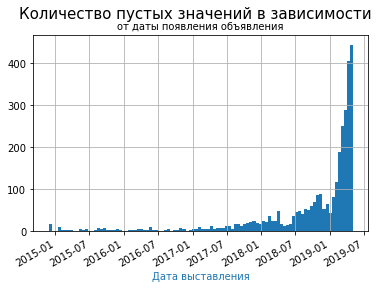

In [10]:
fig, ax = plt.subplots()

x = df.loc[df['days_expositioned'].isnull()]['first_expositioned']

#  график по площади
ax.hist(x, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax.set_xlabel('Дата выставления', fontsize=10, color='tab:blue')
ax.set_title('от даты появления объявления', fontsize=10)
ax.grid(True)

fig.autofmt_xdate()
fig.suptitle('Количество пустых значений в зависимости', fontsize=15)
plt.show()

Видим, что чем более свежие объявления, тем чаще появляются пропущенные значения. Вероятно, значения пропущены потому что эти объявления еще действующие, поэтому возьмём самую свежую дату в датафрейме и посчитаем количество дней для каждого объявления:

In [11]:
try:
    df.loc[(df['days_expositioned'].isnull()), 'days_expositioned'] = (df['first_expositioned'].max() - df['first_expositioned']).dt.days
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['days_expositioned'].isnull().sum())

Пропущено значений: 0


[к началу шага](#2-4) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-5"></a>
### Шаг 2.5 Количество балконов

Теперь возьмём столбец `number_of_balconies`, очевидно, если продавец не указал количество балконов, значит их нет, поэтому просто заменим все пропущенные значения нулём:

In [12]:
try:
    df['number_of_balconies'].fillna(0, inplace=True)
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['number_of_balconies'].isnull().sum())

Пропущено значений: 0


[к началу шага](#2-5) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-6"></a>
### Шаг 2.6 Жилая площадь и площадь кухни

Следующие на очереди &mdash; столбцы `living_area` и `kitchen_area`, для начала взглянем на коэффициенты корреляции:

In [13]:
df.corr()[['living_area', 'kitchen_area']]

,living_area,kitchen_area
total_images,0.104780,0.104756
last_price,0.566492,0.519869
total_area,0.939537,0.609121
number_of_rooms,0.845977,0.269945
ceiling_height,0.090650,0.087641
floors_total,-0.169311,0.163944
living_area,1.000000,0.428674
floor,-0.097210,0.135531
is_studio,-0.056231,NaN
is_open_plan,-0.033711,NaN


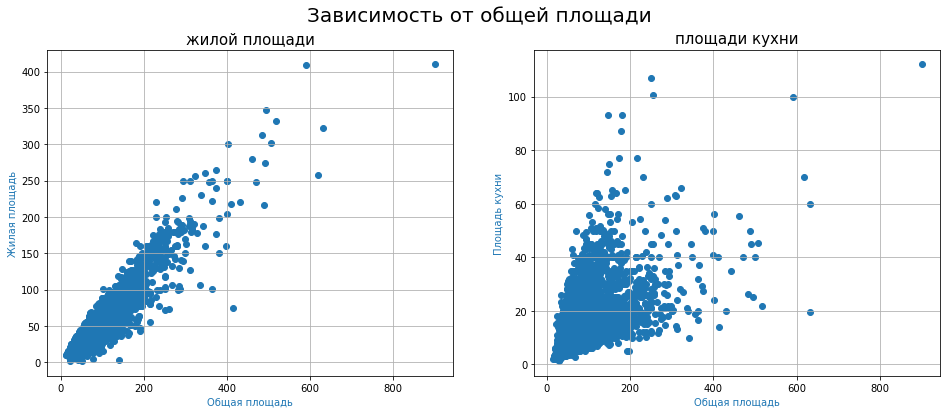

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
x = df['total_area']
y0 = df['living_area']
y1 = df['kitchen_area']

#  график по жилой площади
ax0.scatter(x, y0, c='tab:blue')
ax0.set_xlabel('Общая площадь', fontsize=10, color='tab:blue')
ax0.set_ylabel('Жилая площадь', fontsize=10, color='tab:blue')
ax0.set_title('жилой площади', fontsize=15)
ax0.grid(True)

#  график по площади кухни
ax1.scatter(x, y1, c='tab:blue')
ax1.set_xlabel('Общая площадь', fontsize=10, color='tab:blue')
ax1.set_ylabel('Площадь кухни', fontsize=10, color='tab:blue')
ax1.set_title('площади кухни', fontsize=15)
ax1.grid(True)

fig.suptitle('Зависимость от общей площади', fontsize=20)
plt.show()

Видно, что жилая площадь зависит от общей площади практически линейно, а вот с площадью кухни видим больший разброс. Для начала проверим, есть ли такие строки, где общая площадь меньше, чем сумма жилой площади и площади кухни:

In [15]:
print('Неправильных площадей:', df.loc[(df['total_area'] - df['living_area'] - df['kitchen_area']) < 0]['total_area'].count())

Неправильных площадей: 67


Теперь найдём коэффициенты отношения жилой площади к общей площади  и общей площади без учёта площади кухни (чтобы не получилось так,  что у нас общая площадь оказалась меньше, чем сумма жилой площади и площади кухни). Затем, умножим один из этих коэффициентов (если при применении первого получилась неправильная площадь, применяем второй) на имеющуюся у на общую площадь и получим жилую площадь. Заодно проверим не появилось ли у нас новых неправильных значений. **А еще мы сделаем перый шаг к исправлению неправильных площадей: обнулим площадь кухни и пересчитаем жилую площадь.** 

In [16]:
try:
    k1 = (df['living_area'] / (df['total_area'])).mean()
    k2 = (df['living_area'] / (df['total_area'] - df['kitchen_area'].fillna(0))).mean()
    for row in df.itertuples(name = None):
        if row[8] != row[8]:
            if row[3] * k1 <=  row[3] - row[13]:
                df.loc[row[0], 'living_area'] = row[3] * k1
            elif row[13] != row[13]:
                df.loc[row[0], 'living_area'] = k2 * (row[3])
            else:
                df.loc[row[0], 'living_area'] = k2 * (row[3] - row[13])
        # добавим условие с неправильной площадью
        if row[3] <= row[8] + row[13]:
            df.loc[row[0], 'living_area'] = k2 * (row[3])
            df.loc[row[0], 'kitchen_area'] = np.nan
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['living_area'].isnull().sum())
    print('Неправильных площадей:', df.loc[(df['total_area'] - df['living_area'] - df['kitchen_area']) < 0]['total_area'].count())

Пропущено значений: 0
Неправильных площадей: 0


Теперь проделаем аналогичные манипуляции с площадью кухни, однако добавим немного вариативности:

In [17]:
l = (df['kitchen_area'] / (df['total_area'] - df['living_area'])).mean()
sigma = np.std(df['kitchen_area'] / (df['total_area'] - df['living_area'])) / 3
# создаём функцию для подстановки площади кухни
def kitchen_area_calc(df):
    if df['kitchen_area'] != df['kitchen_area']:
        return random.gauss(l, sigma) * (df['total_area'] - df['living_area'])
    else:
        return df['kitchen_area']

# применяем функцию к таблице
try:
    df['kitchen_area'] = df.apply(kitchen_area_calc, axis=1)
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['kitchen_area'].isnull().sum())
    print('Неправильных площадей:', df.loc[(df['total_area'] - df['living_area'] - df['kitchen_area']) < 0]['total_area'].count())    

Пропущено значений: 0
Неправильных площадей: 0


Отлично! пропущенные значения заполнены, неправильных значений больше **нет**, посмотрим на графики:

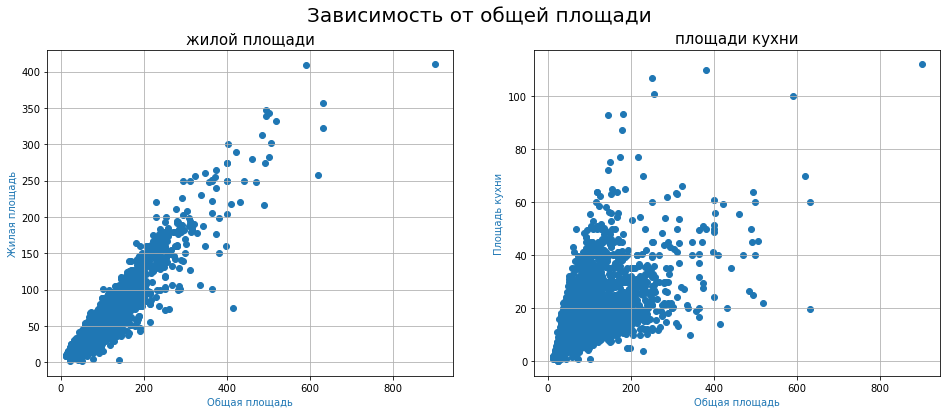

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))
x = df['total_area']
y0 = df['living_area']
y1 = df['kitchen_area']

#  график по жилой площади
ax0.scatter(x, y0, c='tab:blue')
ax0.set_xlabel('Общая площадь', fontsize=10, color='tab:blue')
ax0.set_ylabel('Жилая площадь', fontsize=10, color='tab:blue')
ax0.set_title('жилой площади', fontsize=15)
ax0.grid(True)

#  график по площади кухни
ax1.scatter(x, y1, c='tab:blue')
ax1.set_xlabel('Общая площадь', fontsize=10, color='tab:blue')
ax1.set_ylabel('Площадь кухни', fontsize=10, color='tab:blue')
ax1.set_title('площади кухни', fontsize=15)
ax1.grid(True)

fig.suptitle('Зависимость от общей площади', fontsize=20)
plt.show()

На графиках заметных изменений тоже не видно, значит заметных искажений мы не внесли.

[к началу шага](#2-6) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-7"></a>
### Шаг 2.7 Расстояние до центра города, коды населённых пунктов

Теперь разберемся со столбцом `city_center_distance`, для начала уберём все повторения и унифицируем столбец `locality_name`. Посмотрим на уникальные значения:

In [19]:
print('Количество уникальных значений: ', len(df['locality_name'].unique()))
print(df['locality_name'].unique())

Количество уникальных значений:  365
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогор

Достаточно много значений, и видно, что попадаются одни и те же населенные пункты, но записанные по-разному. Да и в целом, нет унифицированного подхода в записи названия, поэтому сейчас мы это исправим.

Для начала сделаем список уникальных типов населённых пунктов:

In [20]:
try:
    unique_locality_types = sorted(df['locality_name'].unique())
    typelist = list(set([' '.join(filter(str.islower, el.split())) for el in unique_locality_types]))
except:
    print('Ошибка!')
finally:
    print('Список уникальных типов населённых пунктов: \n', typelist, sep='')

Список уникальных типов населённых пунктов: 
['', 'поселок', 'посёлок городского типа', 'село', 'посёлок', 'деревня', 'посёлок 69-й километр', 'садоводческое некоммерческое товарищество', 'поселок станции', 'коттеджный поселок', 'коттеджный посёлок', 'поселок городского типа имени', 'посёлок городского типа имени', 'поселок городского типа', 'садовое товарищество', 'городской поселок', 'посёлок станции', 'городской посёлок', 'посёлок при железнодорожной станции']


Всё нас устраивает, только вот первый элемент нам ни к чему, да и `посёлок 69-й километр` вряд ли относится к типу посёлка, поэтому его тоже уберём. Затем отсортируем все элементы по длине строки по убыванию (чтобы при удалении проверялись сначала длинные строки) и добавим каждой строке пробел в конце (чтобы при удалении не остался лишний пробел): 

In [21]:
try:
    typelist.pop(0)
    typelist.remove('посёлок 69-й километр')
    typelist.sort(key=len, reverse=True)
    typelist = [item + ' ' for item in typelist]
except:
    print('Ошибка!')
finally:
    print('Список уникальных типов населённых пунктов: \n', typelist, sep='')

Список уникальных типов населённых пунктов: 
['садоводческое некоммерческое товарищество ', 'посёлок при железнодорожной станции ', 'поселок городского типа имени ', 'посёлок городского типа имени ', 'посёлок городского типа ', 'поселок городского типа ', 'садовое товарищество ', 'коттеджный поселок ', 'коттеджный посёлок ', 'городской поселок ', 'городской посёлок ', 'поселок станции ', 'посёлок станции ', 'поселок ', 'посёлок ', 'деревня ', 'село ']


А теперь уберём названия типов населённых пунктов из столбца `locality_name`:

In [22]:
try:
    df['locality_name'].replace(typelist, '', regex=True, inplace=True)
except:
    print('Ошибка!')
finally:
    print(df['locality_name'].head(10))
    print('Количество уникальных значений: ', len(df['locality_name'].unique()))

0    Санкт-Петербург
1             Шушары
2    Санкт-Петербург
3    Санкт-Петербург
4    Санкт-Петербург
5            Янино-1
6          Парголово
7    Санкт-Петербург
8             Мурино
9    Санкт-Петербург
Name: locality_name, dtype: object
Количество уникальных значений:  306


Другое дело! И уникальных значений, как видим, стало несколько меньше. Теперь подготовим словари для замены названий населенных пунктов на условные коды:

In [23]:
try:
    localities_names = sorted(df['locality_name'].unique())
    locality_codes = dict(list(zip(localities_names, range(len(localities_names)))))
    locality_dict = dict(list(zip(range(len(localities_names)), localities_names)))
except:
    print('Ошибка!')
finally:
    print('Словарь: ', locality_dict)

Словарь:  {0: 'Unknown', 1: 'Агалатово', 2: 'Александровская', 3: 'Алексеевка', 4: 'Аннино', 5: 'Аро', 6: 'Барышево', 7: 'Батово', 8: 'Бегуницы', 9: 'Белогорка', 10: 'Белоостров', 11: 'Бокситогорск', 12: 'Большая Вруда', 13: 'Большая Ижора', 14: 'Большая Пустомержа', 15: 'Большие Колпаны', 16: 'Большое Рейзино', 17: 'Большой Сабск', 18: 'Бор', 19: 'Борисова Грива', 20: 'Бугры', 21: 'Будогощь', 22: 'Ваганово', 23: 'Важины', 24: 'Вартемяги', 25: 'Вахнова Кара', 26: 'Вещево', 27: 'Виллози', 28: 'Вознесенье', 29: 'Возрождение', 30: 'Войсковицы', 31: 'Войскорово', 32: 'Володарское', 33: 'Волосово', 34: 'Волхов', 35: 'Всеволожск', 36: 'Выборг', 37: 'Вырица', 38: 'Выскатка', 39: 'Высокоключевой', 40: 'Высоцк', 41: 'Гаврилово', 42: 'Гарболово', 43: 'Гатчина', 44: 'Гладкое', 45: 'Глажево', 46: 'Глебычево', 47: 'Глинка', 48: 'Гончарово', 49: 'Горбунки', 50: 'Гостилицы', 51: 'Громово', 52: 'Дзержинского', 53: 'Дружная Горка', 54: 'Дружноселье', 55: 'Дубровка', 56: 'Елизаветино', 57: 'Ефимовский',

Теперь заменим названия на коды, а столбец переименуем на `locality_id`:

In [24]:
try:
    df['locality_name'].replace(to_replace=locality_codes, inplace=True)
    df = df.rename({'locality_name': 'locality_id'}, axis='columns')
except:
    print('Ошибка!')
finally:
    print(df['locality_id'].head(10))

0    224
1    299
2    224
3    224
4    224
5    305
6    171
7    224
8    147
9    224
Name: locality_id, dtype: int64


Далее проверим корреляцию между параметрами и посмотрим на графики:

In [25]:
df['locality_id'].corr(df['city_center_distance'])

-0.46992234827324086

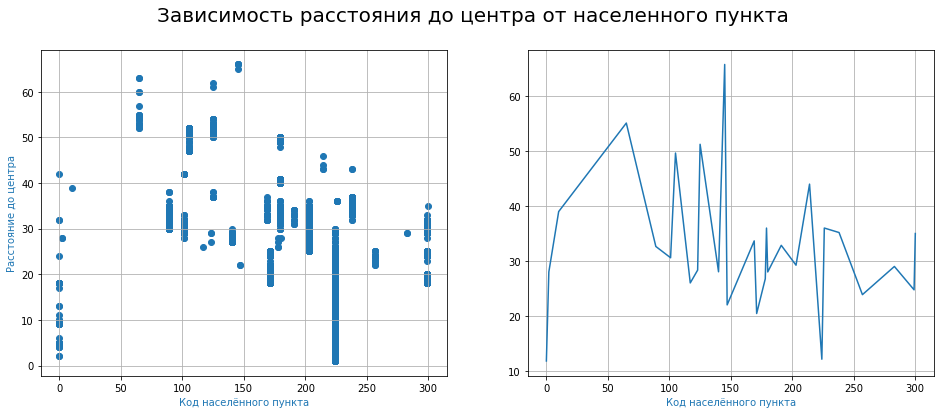

In [26]:
# заменим расстояние в метрах на расстояние в километрах
df['city_center_distance'] = np.ceil(df['city_center_distance'] / 1000)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

x = df['locality_id']
y = df['city_center_distance']
x1 = df.pivot_table(index='locality_id', values='city_center_distance', aggfunc=['mean']).index
y1 = df.pivot_table(index='locality_id', values='city_center_distance', aggfunc=['mean'])[('mean', 'city_center_distance')]

#  график по жилой площади
ax0.scatter(x, y, c='tab:blue')
ax0.set_xlabel('Код населённого пункта', fontsize=10, color='tab:blue')
ax0.set_ylabel('Расстояние до центра', fontsize=10, color='tab:blue')
ax0.grid(True)

#  график по площади кухни
ax1.plot(x1, y1, c='tab:blue', alpha=1, label='Вся область')
ax1.set_xlabel('Код населённого пункта', fontsize=10, color='tab:blue')
ax1.grid(True)

fig.suptitle('Зависимость расстояния до центра от населенного пункта', fontsize=20)
plt.show()

Посмотрим теперь, как дела обстоят с расстоянием до центра в нашем датафрейме:

In [27]:
print('Количество населённых пунктов с пропущенными значениями:', 
      df.loc[df['city_center_distance'].isnull()].groupby('locality_id')['city_center_distance'].count().count())
print('Количество пропущенных значений:', df['city_center_distance'].isnull().sum())

Количество населённых пунктов с пропущенными значениями: 288
Количество пропущенных значений: 5519


Попробуем заполнить пропущенные данные (для тех населённых пунктов, у которых указано расстояние, возьмём среднее по каждому населённому пункту):

In [28]:
try:
    for row in df.itertuples(name = None):
        if row[17] != row[17]:
            df.loc[row[0], 'city_center_distance'] = df[df['locality_id'] == row[15]]['city_center_distance'].mean()
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['city_center_distance'].isnull().sum())

Пропущено значений: 4829


Всё ещё много значений пропущено, получается у некоторых населённых пунктов вообще не указаны расстояния!

In [29]:
print('Количество населённых пунктов с пропущенными значениями:', 
      df.loc[df['city_center_distance'].isnull()].groupby('locality_id')['city_center_distance'].count().count())
print('Количество пропущенных значений:', df['city_center_distance'].isnull().sum())

Количество населённых пунктов с пропущенными значениями: 278
Количество пропущенных значений: 4829


Посмотрим, какие средние расстояния у нас имеются:

In [30]:
df.loc[~df['city_center_distance'].isnull()].groupby('locality_id')['city_center_distance'].mean().sort_values().head(10)

locality_id
0      11.780488
224    12.103512
171    20.428135
147    22.000000
257    23.863636
299    24.740826
117    26.000000
178    26.750000
180    28.000000
2      28.000000
Name: city_center_distance, dtype: float64

Видим, что два первых id находятся достаточно близко друг к другу, 0 &mdash; Unknown, а 224 &mdash; собственно Санкт-Петербург. Значит, определённая часть Unknown значений находится в Санкт-Петербурге. Поэтому ту часть, что точно находится в Санкт-Петербурге мы переименуем:

In [31]:
print('Unknown до:', df.loc[df['locality_id'] == 0]['locality_id'].count())
not_spb_min = df.loc[(df['locality_id'] != 0) & (df['locality_id'] != 224)]['city_center_distance'].min()
try:
    df.loc[(df['locality_id'] == 0) & (df['city_center_distance'] < not_spb_min), 'locality_id'] = 224
except:
    print('Ошибка!')
finally:
    print('Unknown после:', df.loc[df['locality_id'] == 0]['locality_id'].count())
    print(df.loc[~df['city_center_distance'].isnull()].groupby('locality_id')['city_center_distance'].mean().sort_values().head())

Unknown до: 49
Unknown после: 12
locality_id
224    12.094337
171    20.428135
147    22.000000
0      22.833333
257    23.863636
Name: city_center_distance, dtype: float64


Теперь оставшиеся значения заполним средним по всем населенным пунктам кроме Питера:

In [32]:
not_spb_mean = df.loc[(df['locality_id'] != 0) & (df['locality_id'] != 224)]['city_center_distance'].mean()

try:
    df.loc[(df['locality_id'] != 224) & (df['city_center_distance'].isnull()), 'city_center_distance'] = not_spb_mean
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['city_center_distance'].isnull().sum())

Пропущено значений: 0


[к началу шага](#2-7) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-8"></a>
### Шаг 2.8 Аэропорты, парки и зоны отдыха

В столбцах `parks_nearest`, `ponds_nearest` и `airports_nearest` много пропущенных значений, особой смысловой нагрузки они не несут, поэтому просто от них избавимся:

In [33]:
try:
    df = df.drop(columns=['parks_nearest', 'ponds_nearest', 'airports_nearest'])
except:
    print('Ошибка!')
finally:
    print('Заголовки столбцов: \n', df.columns, sep='')

Заголовки столбцов: 
Index(['total_images', 'last_price', 'total_area', 'first_expositioned',
       'number_of_rooms', 'ceiling_height', 'floors_total', 'living_area',
       'floor', 'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area',
       'number_of_balconies', 'locality_id', 'city_center_distance',
       'parks_3km_radius', 'ponds_3km_radius', 'days_expositioned'],
      dtype='object')


Для столбцов `parks_3km_radius` и `ponds_3km_radius` заменим пропущенные значения на 0, так как наиболее вероятно, что пропущенные значения связаны с тем, что в радиус не попали парки или водоёмы:

In [34]:
try:
    df[['parks_3km_radius', 'ponds_3km_radius']] = df[['parks_3km_radius', 'ponds_3km_radius']].fillna(0, inplace=False)
except:
    print('Ошибка!')
finally:
    print('Пропущено значений `parks_3km_radius`:', df['parks_3km_radius'].isnull().sum())
    print('Пропущено значений `ponds_3km_radius`:', df['ponds_3km_radius'].isnull().sum())

Пропущено значений `parks_3km_radius`: 0
Пропущено значений `ponds_3km_radius`: 0


[к началу шага](#2-8) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-9"></a>
### Шаг 2.9 Высота потолка

Уберём неестественные значения для высоты потолка:

In [35]:
df.loc[(df['ceiling_height'] < 2.45) | (df['ceiling_height'] > 5), 'ceiling_height'] = np.nan

Взглянем на корелляцию значения высоты потолка с другими столбцами. Оказывается, наибольшая (но умеренная) связь наблюдается со столбцом `total_area`.

In [36]:
df.corr()['ceiling_height'].sort_values(ascending=False)

ceiling_height          1.000000
total_area              0.479240
living_area             0.449553
kitchen_area            0.407734
last_price              0.386837
number_of_rooms         0.299570
parks_3km_radius        0.295360
ponds_3km_radius        0.269021
days_expositioned       0.143680
locality_id             0.120968
total_images            0.042961
is_open_plan            0.012702
is_studio               0.009185
floor                  -0.049869
number_of_balconies    -0.077748
floors_total           -0.096451
city_center_distance   -0.380968
Name: ceiling_height, dtype: float64

Посмотрим на зависимость высоты полтолка от общей площади:

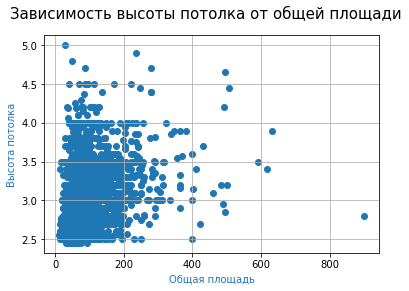

In [37]:
fig, ax = plt.subplots()

x = df['total_area']
y = df['ceiling_height']

#  график по жилой площади
ax.scatter(x, y, c='tab:blue')
ax.set_xlabel('Общая площадь', fontsize=10, color='tab:blue')
ax.set_ylabel('Высота потолка', fontsize=10, color='tab:blue')
ax.grid(True)

fig.suptitle('Зависимость высоты потолка от общей площади', fontsize=15)
plt.show()

Попробуем применить линейную регрессию:

Середина: -7212
Коэффициент 0.30621702203706175


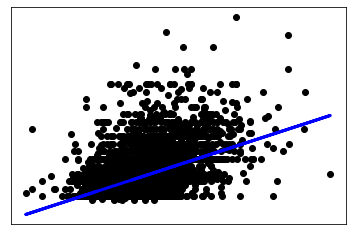

In [38]:
dataset = df.loc[~df['ceiling_height'].isnull()]
half = -int(len(dataset) / 2)
print('Середина:', half)

ceiling_X = np.log(dataset[['total_area']])
ceiling_y = dataset[['ceiling_height']]
ceiling_X_train = ceiling_X[:half]
ceiling_X_test = ceiling_X[half:]
ceiling_y_train = ceiling_y[:half]
ceiling_y_test = ceiling_y[half:]

regr = linear_model.LinearRegression()
regr.fit(ceiling_X_train, ceiling_y_train)

ceiling_y_pred = regr.predict(ceiling_X_test)

# The coefficients
k = float(regr.coef_)
print('Коэффициент', k)

# Plot outputs
plt.scatter(ceiling_X_test, ceiling_y_test,  color='black')
plt.plot(ceiling_X_test, ceiling_y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

Воспользуемся результатами:

In [39]:
try:
    df.loc[df['ceiling_height'].isnull(), 'ceiling_height'] = 1.67 + k*np.log(df['total_area'])
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['ceiling_height'].isnull().sum())

Пропущено значений: 0


Снова взглянем на график:

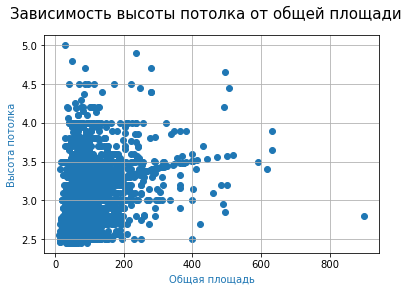

In [40]:
fig, ax = plt.subplots()

x = df['total_area']
y = df['ceiling_height']

#  график по жилой площади
ax.scatter(x, y, c='tab:blue')
ax.set_xlabel('Общая площадь', fontsize=10, color='tab:blue')
ax.set_ylabel('Высота потолка', fontsize=10, color='tab:blue')
ax.grid(True)

fig.suptitle('Зависимость высоты потолка от общей площади', fontsize=15)
plt.show()

[к началу шага](#2-9) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-10"></a>
### Шаг 2.10 Количество этажей в доме

Теперь разберемся с количеством этажей в доме, для начала взглянем на график:

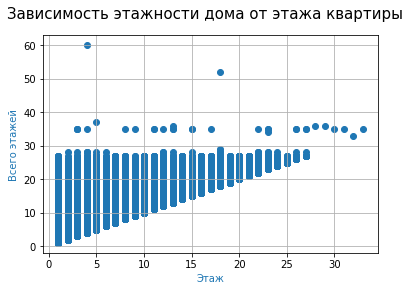

In [41]:
fig, ax = plt.subplots()

x = df['floor']
y = df['floors_total']

#  график по этажам
ax.scatter(x, y, c='tab:blue')
ax.set_xlabel('Этаж', fontsize=10, color='tab:blue')
ax.set_ylabel('Всего этажей', fontsize=10, color='tab:blue')
ax.grid(True)

fig.suptitle('Зависимость этажности дома от этажа квартиры', fontsize=15)
plt.show()

Видим, что, очевидно, количество этажей в доме не может быть меньше, чем этаж квартиры, в остальном распределение достаточно равномероное. Создадим функцию для подбора этажа и применим её:

In [42]:
mu = df['floors_total'].mean()
sigma = np.std(df['floors_total'])

# создаём функцию для определения количества этажей в доме
def floors_total_calc(df):
    if df['floors_total'] != df['floors_total']:
        floors_total = int(random.gauss(mu, sigma))
        return floors_total if floors_total > df['floor'] else df['floor'] 
    return df['floors_total']
# применяем функцию
try:
    df['floors_total'] = df.apply(floors_total_calc, axis=1)
except:
    print('Ошибка!')
finally:
    print('Пропущено значений:', df['floors_total'].isnull().sum())    

Пропущено значений: 0


Снова взглянем на график:

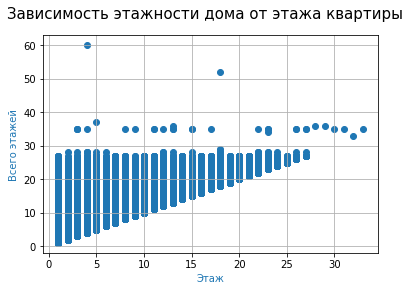

In [43]:
fig, ax = plt.subplots()

x = df['floor']
y = df['floors_total']

#  график по этажам
ax.scatter(x, y, c='tab:blue')
ax.set_xlabel('Этаж', fontsize=10, color='tab:blue')
ax.set_ylabel('Всего этажей', fontsize=10, color='tab:blue')
ax.grid(True)

fig.suptitle('Зависимость этажности дома от этажа квартиры', fontsize=15)
plt.show()

Выбросов не случилось, значит наши действия сильно не исказили обстановку.

[к началу шага](#2-10) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-11"></a>
### Шаг 2.11 Преобразование типов данных, округление

Посмотрим общую информацию:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_expositioned    23699 non-null  datetime64[ns]
 4   number_of_rooms       23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  is_studio             23699 non-null  bool          
 11  is_open_plan          23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  number_of_balcon

Мы разобрались почти со всеми пропущенными значениями, но у нас остался столбец `is_apartment` с огромным количеством пропущенных значений. При этом найти хоть сколько либо значимых зависимостей не удалось, а удалять столбец не стоит, так как он содержит данные, непосредственно влияющие на цену. Поэтому решено ничего с ним не делать.

Преобразуем типы данных:

In [45]:
try:
    df['days_expositioned'] = df['days_expositioned'].astype('int')
    df['total_images'] = df['total_images'].astype('int')
    df['last_price'] = df['last_price'].astype('int')
    df['number_of_rooms'] = df['number_of_rooms'].astype('int')
    df['number_of_balconies'] = df['number_of_balconies'].astype('int')
    df['floor'] = df['floor'].astype('int')
    df['floors_total'] = df['floors_total'].astype('int')
    df['locality_id'] = df['locality_id'].astype('int')
    df['city_center_distance'] = df['city_center_distance'].astype('int')
    df['parks_3km_radius'] = df['parks_3km_radius'].astype('int')
    df['ponds_3km_radius'] = df['ponds_3km_radius'].astype('int')
except:
    print('Ошибка!')
finally:
    print('Типы данных: \n', df.dtypes, sep='')    

Типы данных: 
total_images                     int32
last_price                       int32
total_area                     float64
first_expositioned      datetime64[ns]
number_of_rooms                  int32
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int32
is_apartment                    object
is_studio                         bool
is_open_plan                      bool
kitchen_area                   float64
number_of_balconies              int32
locality_id                      int32
city_center_distance             int32
parks_3km_radius                 int32
ponds_3km_radius                 int32
days_expositioned                int32
dtype: object


Округлим дроби:

In [46]:
try:
    df['living_area'] = df['living_area'].round(2)
    df['kitchen_area'] = df['kitchen_area'].round(2)
except:
    print('Ошибка!')
finally:
    display(df[['living_area', 'kitchen_area']].head(10))    

,living_area,kitchen_area
0,51.00,25.00
1,18.60,11.00
2,34.30,8.30
3,109.20,21.79
4,32.00,41.00
5,14.40,9.10
6,10.60,14.40
7,40.44,18.90
8,15.43,8.81
9,43.60,6.50


Оценим общую информацию:

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int32         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_expositioned    23699 non-null  datetime64[ns]
 4   number_of_rooms       23699 non-null  int32         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int32         
 9   is_apartment          2775 non-null   object        
 10  is_studio             23699 non-null  bool          
 11  is_open_plan          23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  number_of_balcon

In [48]:
df.head(10)

,total_images,last_price,total_area,first_expositioned,number_of_rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,is_open_plan,kitchen_area,number_of_balconies,locality_id,city_center_distance,parks_3km_radius,ponds_3km_radius,days_expositioned
0,20,13000000,108.00,2019-03-07,3,2.700000,16,51.00,8,NaN,False,False,25.00,0,224,17,1,2,57
1,7,3350000,40.40,2018-12-04,1,2.802645,11,18.60,1,NaN,False,False,11.00,2,299,19,0,0,81
2,10,5196000,56.00,2015-08-20,2,2.902631,5,34.30,4,NaN,False,False,8.30,0,224,14,1,2,558
3,0,64900000,159.00,2015-07-24,3,3.222185,14,109.20,9,NaN,False,False,21.79,0,224,7,2,3,424
4,2,10000000,100.00,2018-06-19,2,3.030000,14,32.00,13,NaN,False,False,41.00,0,224,9,2,1,121
5,10,2890000,30.40,2018-09-10,1,2.715560,12,14.40,5,NaN,False,False,9.10,0,305,29,0,0,55
6,6,3700000,37.30,2017-11-02,1,2.778197,26,10.60,6,NaN,False,False,14.40,1,171,20,0,0,155
7,5,7915000,71.60,2019-04-18,2,2.977882,24,40.44,22,NaN,False,False,18.90,2,224,12,0,0,15
8,20,2900000,33.16,2018-05-23,1,2.742171,27,15.43,26,NaN,False,False,8.81,0,147,22,0,0,189
9,18,5400000,61.00,2017-02-26,3,2.500000,9,43.60,7,NaN,False,False,6.50,2,224,16,0,0,289


[к началу шага](#2-11) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-12"></a>
### Шаг 2.12 Выводы по второму этапу

На этапе предобработки в данных обнаружились проблемы с названиями столбцов, пропуски и дубликаты. Их удаление позволит провести анализ точнее. Имена столбцов теперь корректны и удобны для дальнейшей работы. Мы очистили столбец с названиями населённых пунктов от дубликатов и заменили его на столбец с кодом города. Восстановили пропущенные значения при помощи случайных распределений, заполнения средними и линейной регрессии.

[к началу шага](#2-3) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="3"></a>
## Этап 3. Добавляем новые столбцы

<a id="3-1"></a>
### Шаг 3.1 Цена за квадратный метр

Посчитаем и добавим в таблицу цену за квадратный метр, для этого разделим столбец с ценой на столбец с общей площадью, присвоим результат новому столбцу и приведем полученные результаты к формату `int`:

In [49]:
try:
    df['square_meter_price'] = (df['last_price'] / df['total_area'])
    df['square_meter_price'] = df['square_meter_price'].astype('int')
except:
    print('Ошибка!')
finally:
    print(df['square_meter_price'].head(10))

0    120370
1     82920
2     92785
3    408176
4    100000
5     95065
6     99195
7    110544
8     87454
9     88524
Name: square_meter_price, dtype: int32


[к началу шага](#3-1) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-2"></a>
### Шаг 3.2 День, месяц и год выставления на продажу

Чтобы добавить столбцы с данными о дне недели, месяце и годе выставления объявления воспользуемся соответственно методами `.weekday`, `.month` и `.year`. Затем приведем значения к типу `int`:

In [50]:
try:
    df['first_expositioned_weekday'] = pd.DatetimeIndex(df['first_expositioned']).weekday
    df['first_expositioned_month'] = pd.DatetimeIndex(df['first_expositioned']).month
    df['first_expositioned_year'] = pd.DatetimeIndex(df['first_expositioned']).year
    df['first_expositioned_weekday'] = df['first_expositioned_weekday'].astype('int')
    df['first_expositioned_month'] = df['first_expositioned_month'].astype('int')
    df['first_expositioned_year'] = df['first_expositioned_year'].astype('int')
except:
    print('Ошибка!')
finally:
    display(df[['first_expositioned_weekday', 'first_expositioned_month', 'first_expositioned_year']].head(10))

,first_expositioned_weekday,first_expositioned_month,first_expositioned_year
0,3,3,2019
1,1,12,2018
2,3,8,2015
3,4,7,2015
4,1,6,2018
5,0,9,2018
6,3,11,2017
7,3,4,2019
8,2,5,2018
9,6,2,2017


[к началу шага](#3-2) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-3"></a>
### Шаг 3.3 Категория этажа

В случае с категоризацией этажей дела обстоят чуть сложнее. Напишем функцию, которая в зависимости от условий присваивает категорию этажа "единственный" (когда дом одноэтажный), "первый", "последний" и "другой" (если не попал ни водну из предыдущих категорий":

In [51]:
floor_type_dict = {
    0: 'единственный',
    1: 'первый',
    2: 'другой',
    3: 'последний'
}

def floor_categoriser(df):
    if df['floor'] == 1:
        return 0 if df['floor'] == df['floors_total'] else 1     
    elif df['floor'] == df['floors_total']:
        return 3
    return 2

try:
    df['floor_type'] = df.apply(floor_categoriser, axis=1)
except:
    print('Ошибка!')
finally:
    print(df.groupby('floor_type')['floor_type'].count())

floor_type
0       25
1     2892
2    17403
3     3379
Name: floor_type, dtype: int64


[к началу шага](#3-3) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-4"></a>
### Шаг 3.4 Отношения жилой площади и площади кухни к общей площади

Найдём отношение жилой площади и площади кухни к общей площади. Для этого жилую площадь и площадь кухни разделим на общую площадь, результаты сохраним в соответствующие столбцы, значения округлим до 2-х знаков после запятой:

In [52]:
try:
    df['living_to_total_area'] = df['living_area'] / df['total_area']
    df['kitchen_to_total_area'] = df['kitchen_area'] / df['total_area']
    df['living_to_total_area'] = df['living_to_total_area'].round(2)
    df['kitchen_to_total_area'] = df['kitchen_to_total_area'].round(2)
except:
    print('Ошибка!')
finally:
    print(df[['living_to_total_area', 'kitchen_to_total_area']].head(10))

   living_to_total_area  kitchen_to_total_area
0                  0.47                   0.23
1                  0.46                   0.27
2                  0.61                   0.15
3                  0.69                   0.14
4                  0.32                   0.41
5                  0.47                   0.30
6                  0.28                   0.39
7                  0.56                   0.26
8                  0.47                   0.27
9                  0.71                   0.11


[к началу шага](#3-4) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-5"></a>
### Шаг 3.5 Стоимость в миллионах рублей

Для удобства при построении графиков заранее переведём стоимость в миллионы рублей и сохраним в новый столбец, значения округлим до двух знаков после запятой:

In [53]:
try:
    df['last_price_mln'] = df['last_price'] / 1_000_000
    df['last_price_mln'] = df['last_price_mln'].round(2)
except:
    print('Ошибка!')
finally:
    print(df['last_price_mln'].head(10))

0    13.00
1     3.35
2     5.20
3    64.90
4    10.00
5     2.89
6     3.70
7     7.92
8     2.90
9     5.40
Name: last_price_mln, dtype: float64


[к началу шага](#3-5) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-6"></a>
### Шаг 3.6 Новый порядок столбцов

А еще мы подготовим новый, более осмысленный порядок столбцов. Этот порядок основан на группировке столбцов по категориям:

- **Объявление**
    - Дата размещения
    - День недели размещения
    - Месяц размещения
    - Год размещения
    - Продолжительность размещения
    - Количество фотографий
    - Цена
    - Цена, млн руб
    - Цена за кв метр
- **Характеристики квартиры / апартаментов**
    - Количество комнат
    - Общая площадь
    - Жилая площадь
    - Отношение жилой площади к общей площади
    - Площадь кухни
    - Отношение площади кухни к общей площади
    - Высота потолка
    - Наличие балкона
    - Этаж
    - Этажей в доме
    - Тип этажа
    - Студия
    - Свободная планировка
    - Апартаменты
- **Расположение квартиры**
    - Населенный пункт / район
    - Расстояние до центра
    - Количество парков в радиусе 3 км
    - Количество водоёмов в радиусе 3 км

Выведем названия столбцов:

In [54]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_expositioned',
       'number_of_rooms', 'ceiling_height', 'floors_total', 'living_area',
       'floor', 'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area',
       'number_of_balconies', 'locality_id', 'city_center_distance',
       'parks_3km_radius', 'ponds_3km_radius', 'days_expositioned',
       'square_meter_price', 'first_expositioned_weekday',
       'first_expositioned_month', 'first_expositioned_year', 'floor_type',
       'living_to_total_area', 'kitchen_to_total_area', 'last_price_mln'],
      dtype='object')

Теперь сохраним новый порядок в список и применим его к датафрейму:

In [55]:
cols = ['first_expositioned',
        'first_expositioned_weekday',
        'first_expositioned_month', 
        'first_expositioned_year',
        'days_expositioned',
        'total_images',
        'last_price',
        'last_price_mln',
        'square_meter_price',
        'number_of_rooms',
        'total_area',
        'living_area',
        'living_to_total_area',
        'kitchen_area',
        'kitchen_to_total_area',
        'ceiling_height',
        'number_of_balconies',
        'floor',
        'floors_total',
        'floor_type',
        'is_studio',
        'is_open_plan',
        'is_apartment',
        'locality_id', 
        'city_center_distance',
        'parks_3km_radius', 
        'ponds_3km_radius']

try:
    df = df[cols]
except:
    print('Ошибка!')
finally:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   first_expositioned          23699 non-null  datetime64[ns]
 1   first_expositioned_weekday  23699 non-null  int32         
 2   first_expositioned_month    23699 non-null  int32         
 3   first_expositioned_year     23699 non-null  int32         
 4   days_expositioned           23699 non-null  int32         
 5   total_images                23699 non-null  int32         
 6   last_price                  23699 non-null  int32         
 7   last_price_mln              23699 non-null  float64       
 8   square_meter_price          23699 non-null  int32         
 9   number_of_rooms             23699 non-null  int32         
 10  total_area                  23699 non-null  float64       
 11  living_area                 23699 non-null  float64   

In [56]:
df.head(10)

,first_expositioned,first_expositioned_weekday,first_expositioned_month,first_expositioned_year,days_expositioned,total_images,last_price,last_price_mln,square_meter_price,number_of_rooms,...,floor,floors_total,floor_type,is_studio,is_open_plan,is_apartment,locality_id,city_center_distance,parks_3km_radius,ponds_3km_radius
0,2019-03-07,3,3,2019,57,20,13000000,13.00,120370,3,...,8,16,2,False,False,NaN,224,17,1,2
1,2018-12-04,1,12,2018,81,7,3350000,3.35,82920,1,...,1,11,1,False,False,NaN,299,19,0,0
2,2015-08-20,3,8,2015,558,10,5196000,5.20,92785,2,...,4,5,2,False,False,NaN,224,14,1,2
3,2015-07-24,4,7,2015,424,0,64900000,64.90,408176,3,...,9,14,2,False,False,NaN,224,7,2,3
4,2018-06-19,1,6,2018,121,2,10000000,10.00,100000,2,...,13,14,2,False,False,NaN,224,9,2,1
5,2018-09-10,0,9,2018,55,10,2890000,2.89,95065,1,...,5,12,2,False,False,NaN,305,29,0,0
6,2017-11-02,3,11,2017,155,6,3700000,3.70,99195,1,...,6,26,2,False,False,NaN,171,20,0,0
7,2019-04-18,3,4,2019,15,5,7915000,7.92,110544,2,...,22,24,2,False,False,NaN,224,12,0,0
8,2018-05-23,2,5,2018,189,20,2900000,2.90,87454,1,...,26,27,2,False,False,NaN,147,22,0,0
9,2017-02-26,6,2,2017,289,18,5400000,5.40,88524,3,...,7,9,2,False,False,NaN,224,16,0,0


[к началу шага](#3-6) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-7"></a>
### Шаг 3.7 Выводы по третьему этапу

На этом этапе мы добавили в датафрейм новые столбцы: стоимость за квадратный метр, день недели, месяц и год выставления объявления, категорию этажа, отношение жилой и кухонной площади к общей площади, а также цену в миллионах рублей. Кроме того, мы, для удобства, заменили порядок столбцов.

[к началу шага](#3-7) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="4"></a>
## Этап 4. Исследовательский анализ данных

<a id="4-1"></a>
### Шаг 4.1 Изучаем площадь, цену, число комнат и высоту потолков

Для изучения указанных параметров построим для наглядности гистограммы:

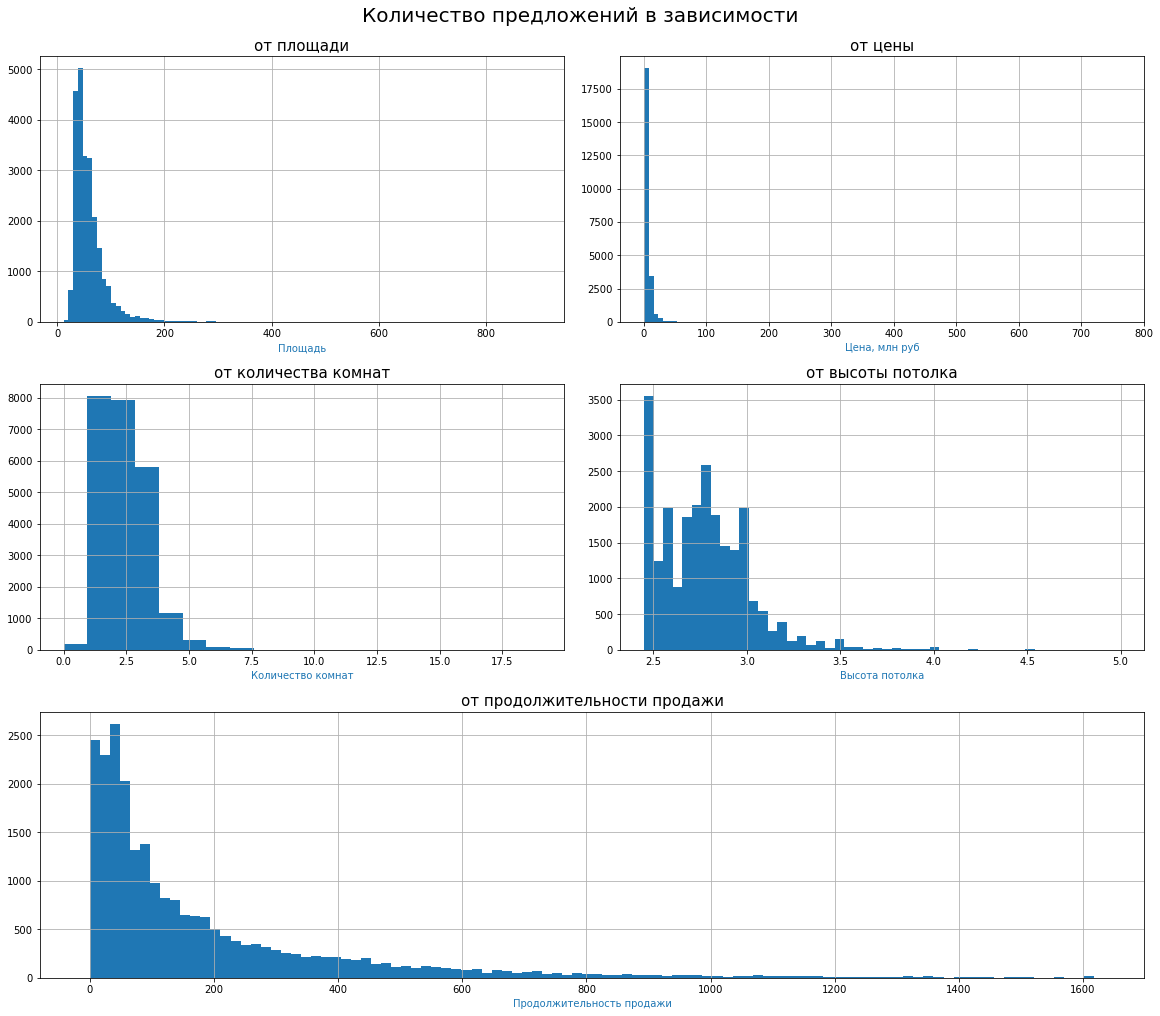

In [57]:
fig = plt.figure(constrained_layout=True, figsize=(16,14))

gs = GridSpec(3, 2, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, :])


x0 = df['total_area']
x1 = df['last_price_mln']
x2 = df['number_of_rooms']
x3 = df['ceiling_height']
x4 = df['days_expositioned']

#  график по площади
ax0.hist(x0, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax0.set_xlabel('Площадь', fontsize=10, color='tab:blue')
ax0.set_title('от площади', fontsize=15)
ax0.grid(True)

#  график по цене
ax1.hist(x1, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax1.set_xlabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.set_title('от цены', fontsize=15)
ax1.grid(True)

#  график по комнатам
ax2.hist(x2, 20, facecolor='tab:blue', alpha=1, label='Вся область')
ax2.set_xlabel('Количество комнат', fontsize=10, color='tab:blue')
ax2.set_title('от количества комнат', fontsize=15)
ax2.grid(True)

# график по высоте потолка
ax3.hist(x3, 50, facecolor='tab:blue', alpha=1, label='Вся область')
ax3.set_xlabel('Высота потолка', fontsize=10, color='tab:blue')
ax3.set_title('от высоты потолка', fontsize=15)
ax3.grid(True)

# график по времени продажи
ax4.hist(x4, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax4.set_xlabel('Продолжительность продажи', fontsize=10, color='tab:blue')
ax4.set_title('от продолжительности продажи', fontsize=15)
ax4.grid(True)

fig.suptitle('Количество предложений в зависимости', fontsize=20)
plt.show()

А с помощью метода `.describe()` получим основные показатели:

In [58]:
df[['total_area', 'last_price_mln', 'number_of_rooms', 'ceiling_height', 'days_expositioned']].describe().round(2)

,total_area,last_price_mln,number_of_rooms,ceiling_height,days_expositioned
count,23699.00,23699.00,23699.00,23699.00,23699.00
mean,60.35,6.54,2.07,2.79,185.82
std,35.65,10.89,1.08,0.24,233.38
min,12.00,0.01,0.00,2.45,0.00
25%,40.00,3.40,1.00,2.60,43.00
50%,52.00,4.65,2.00,2.76,94.00
75%,69.90,6.80,3.00,2.92,237.00
max,900.00,763.00,19.00,5.00,1618.00


Видим, что по всем показателям медиана ниже среднего, значит большая часть значений находится левее среднего, а по правую часть находятся экстремальные значения, которые тянут среднее вправо. Взглянув на графики, мы можем убедиться, что так оно и есть. При этом, явно выбивающихся значений нет только в столбце с высотой полтолков, однако это результат нашего вмешательства.

Касаемо длительности продажи можно сказать следующее: очень быстрой продажей будут считаться сделки, заключенные быстрее, чем за 43 дня. А необычайно долгими будут считаться продажи, по которым нет сделки более 237 дней.

[к началу шага](#4-1) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-2"></a>
### Шаг 4.2 Редкие и выбивающиеся значения

Взглянем на весь датафрейм и оценим наличие редких и выбивающихся значений:

In [59]:
pd.set_option('display.max_columns', None)
df.describe()

,first_expositioned_weekday,first_expositioned_month,first_expositioned_year,days_expositioned,total_images,last_price,last_price_mln,square_meter_price,number_of_rooms,total_area,living_area,living_to_total_area,kitchen_area,kitchen_to_total_area,ceiling_height,number_of_balconies,floor,floors_total,floor_type,locality_id,city_center_distance,parks_3km_radius,ponds_3km_radius
count,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,2.369900e+04,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000
mean,2.569307,6.400101,2017.367146,185.821722,9.858475,6.541549e+06,6.541597,9.942121e+04,2.070636,60.348651,34.987698,0.571749,10.282252,0.182081,2.787534,0.591080,5.892358,10.684670,2.018440,198.244188,17.809443,0.469049,0.590911
std,1.789082,3.491561,1.039771,233.380877,5.682529,1.088701e+07,10.887011,5.030681e+04,1.078405,35.654083,22.744021,0.104371,5.955163,0.070792,0.238461,0.959298,4.885249,6.595547,0.518171,60.394667,9.528339,0.748534,0.883999
min,0.000000,1.000000,2014.000000,0.000000,0.000000,1.219000e+04,0.010000,1.110000e+02,0.000000,12.000000,2.000000,0.020000,0.000000,0.000000,2.450000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,2017.000000,43.000000,6.000000,3.400000e+06,3.400000,7.658500e+04,1.000000,40.000000,19.000000,0.500000,7.000000,0.130000,2.600000,0.000000,2.000000,5.000000,2.000000,203.000000,11.000000,0.000000,0.000000
50%,3.000000,6.000000,2017.000000,94.000000,9.000000,4.650000e+06,4.650000,9.500000e+04,2.000000,52.000000,30.200000,0.570000,9.000000,0.160000,2.763999,0.000000,4.000000,9.000000,2.000000,224.000000,15.000000,0.000000,0.000000
75%,4.000000,10.000000,2018.000000,237.000000,14.000000,6.800000e+06,6.800000,1.142560e+05,3.000000,69.900000,42.600000,0.650000,11.700000,0.220000,2.918611,1.000000,8.000000,16.000000,2.000000,224.000000,29.000000,1.000000,1.000000
max,6.000000,12.000000,2019.000000,1618.000000,50.000000,7.630000e+08,763.000000,1.907500e+06,19.000000,900.000000,409.700000,1.000000,112.000000,0.720000,5.000000,5.000000,33.000000,60.000000,3.000000,305.000000,66.000000,3.000000,3.000000


При осмотре видим, что сильно выбиваются значения в столбцах `days_expositioned`, `last_price_mln`, `number_of_rooms`, `total_area` и `living_area`. Остальные столбцы либо не имеют выбивающихся значений, либо производные от этих столбцов. Взглянем на них поближе:

Посмотрим на минимальные и максимальные значения площадей:

In [60]:
print(df['total_area'].nlargest(10))
print(df['total_area'].nsmallest(10))
print()
print(df['living_area'].nlargest(10))
print(df['living_area'].nsmallest(10))
print()
print(df['kitchen_area'].nlargest(10))
print(df['kitchen_area'].nsmallest(10))

19540    900.0
12859    631.2
3117     631.0
15651    618.0
5358     590.0
4237     517.0
8018     507.0
5893     500.0
15016    500.0
12401    495.0
Name: total_area, dtype: float64
19904    12.0
17961    13.0
19546    13.0
19807    13.0
19558    13.2
19642    14.0
12040    15.0
16949    15.0
8886     15.5
9412     16.0
Name: total_area, dtype: float64

19540    409.70
5358     409.00
3117     356.37
12401    347.50
15016    343.40
9826     339.34
4237     332.00
12859    322.30
660      312.50
8018     301.50
Name: living_area, dtype: float64
13915    2.0
21758    2.0
3242     3.0
23574    3.0
17582    5.0
21943    5.4
16431    6.0
19251    6.5
20994    8.0
23208    8.0
Name: living_area, dtype: float64

19540    112.00
7674     110.01
20215    107.00
2489     100.70
5358     100.00
16239     93.20
16797     93.00
10867     87.20
492       77.00
4394      77.00
Name: kitchen_area, dtype: float64
9861     0.00
12691    0.00
10606    0.12
2959     0.63
20256    0.72
12996    0.79
19268

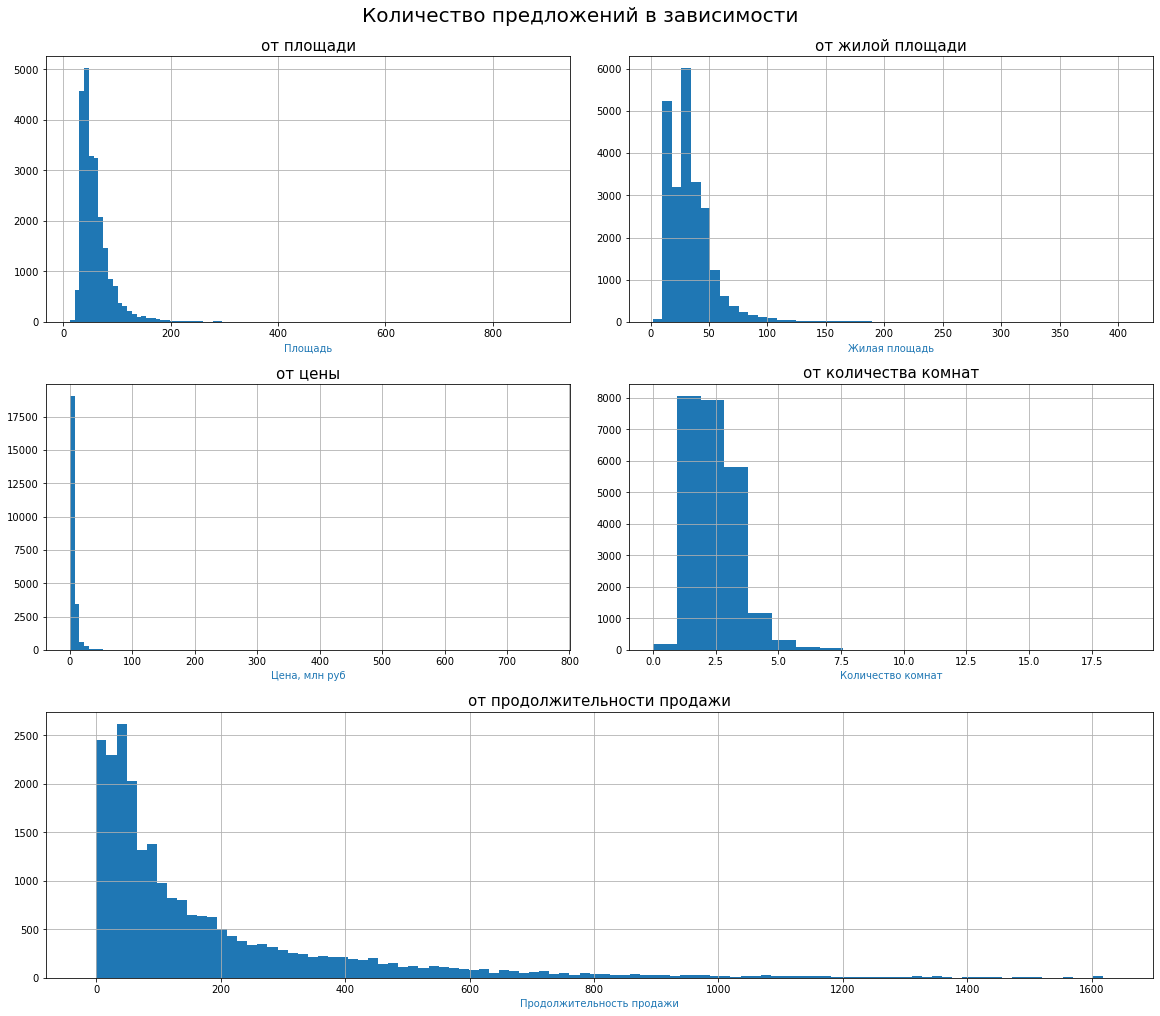

In [61]:
fig = plt.figure(constrained_layout=True, figsize=(16,14))

gs = GridSpec(3, 2, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, :])


x0 = df['total_area']
x1 = df['living_area']
x2 = df['last_price_mln']
x3 = df['number_of_rooms']
x4 = df['days_expositioned']

#  график по площади
ax0.hist(x0, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax0.set_xlabel('Площадь', fontsize=10, color='tab:blue')
ax0.set_title('от площади', fontsize=15)
ax0.grid(True)

# график по высоте потолка
ax1.hist(x1, 50, facecolor='tab:blue', alpha=1, label='Вся область')
ax1.set_xlabel('Жилая площадь', fontsize=10, color='tab:blue')
ax1.set_title('от жилой площади', fontsize=15)
ax1.grid(True)

#  график по цене
ax2.hist(x2, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax2.set_xlabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.set_title('от цены', fontsize=15)
ax2.grid(True)

#  график по комнатам
ax3.hist(x3, 20, facecolor='tab:blue', alpha=1, label='Вся область')
ax3.set_xlabel('Количество комнат', fontsize=10, color='tab:blue')
ax3.set_title('от количества комнат', fontsize=15)
ax3.grid(True)


# график по времени продажи
ax4.hist(x4, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax4.set_xlabel('Продолжительность продажи', fontsize=10, color='tab:blue')
ax4.set_title('от продолжительности продажи', fontsize=15)
ax4.grid(True)

fig.suptitle('Количество предложений в зависимости', fontsize=20)
plt.show()

И еще раз взглянем на основные показатели:

In [62]:
df[['total_area', 'living_area', 'kitchen_area', 'last_price_mln', 'number_of_rooms', 'days_expositioned']].describe().round(2)

,total_area,living_area,kitchen_area,last_price_mln,number_of_rooms,days_expositioned
count,23699.00,23699.00,23699.00,23699.00,23699.00,23699.00
mean,60.35,34.99,10.28,6.54,2.07,185.82
std,35.65,22.74,5.96,10.89,1.08,233.38
min,12.00,2.00,0.00,0.01,0.00,0.00
25%,40.00,19.00,7.00,3.40,1.00,43.00
50%,52.00,30.20,9.00,4.65,2.00,94.00
75%,69.90,42.60,11.70,6.80,3.00,237.00
max,900.00,409.70,112.00,763.00,19.00,1618.00


И на матрицу графиков зависимостей:

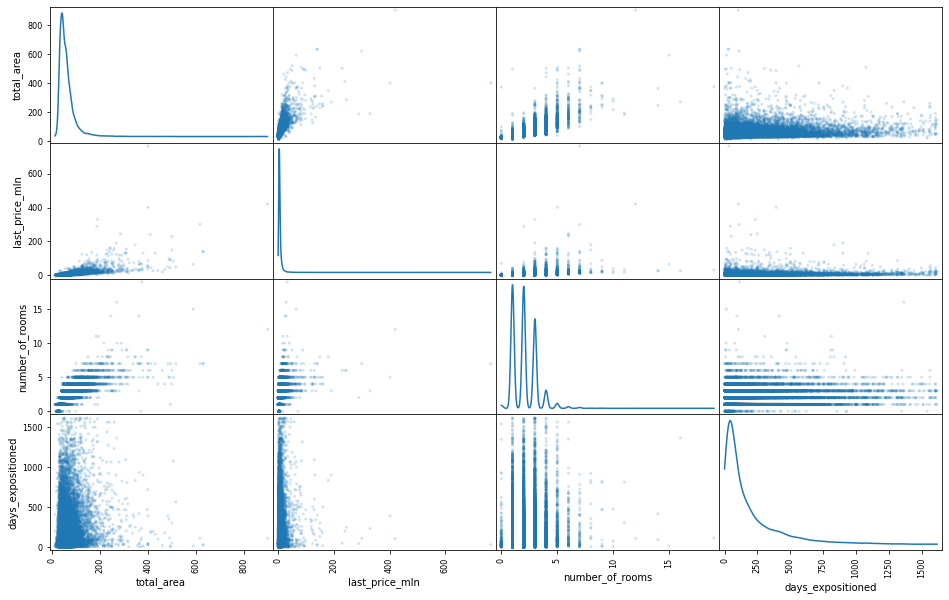

In [63]:
pd.plotting.scatter_matrix(df[['total_area', 'last_price_mln', 'number_of_rooms', 'days_expositioned']], alpha=0.2, figsize=(16, 10), diagonal='kde')
plt.show()

Видно, что для столбца `days_expositioned` редкие значения после 1250 дней, для `last_price_mln` &mdash; после 200 млн руб, для `number_of_rooms` &mdash; после 7 комнат, а для `total_area` &mdash; после 400 кв метров. Кроме того, странным кажется количество комнат равное нулю, площадь квартиры меньше 28 метров, жилая площадь меньше 14 метров или площадь кухни меньше 5 метров, а так же цена квартиры в 12 тысяч рублей. Попробуем избавиться от этих значений:

In [64]:
try:
    df.drop(df[df['days_expositioned'] > 1250].index, axis=0, inplace=True)
    df.drop(df[(df['last_price_mln'] > 200) | (df['last_price_mln'] < 0.4)].index, axis=0, inplace=True)
    df.drop(df[(df['number_of_rooms'] > 7) | (df['number_of_rooms'] == 0)].index, axis=0, inplace=True)
    df.drop(df[(df['total_area'] > 400) | (df['total_area'] < 28)].index, axis=0, inplace=True)
    df.drop(df[df['living_area'] < 14].index, axis=0, inplace=True)
    df.drop(df[df['kitchen_area'] < 5].index, axis=0, inplace=True)
except:
    print('Ошибка!')
finally:
    display(df[['total_area', 'living_area', 'kitchen_area', 'last_price_mln', 'number_of_rooms', 'days_expositioned']].describe().round(2))

,total_area,living_area,kitchen_area,last_price_mln,number_of_rooms,days_expositioned
count,22332.00,22332.00,22332.00,22332.00,22332.00,22332.00
mean,60.77,35.23,10.39,6.42,2.11,180.13
std,31.37,20.52,5.63,7.46,1.01,213.38
min,28.00,14.00,5.00,0.43,1.00,0.00
25%,41.40,19.80,7.00,3.50,1.00,43.00
50%,53.21,31.00,9.00,4.74,2.00,95.00
75%,70.00,43.00,11.78,6.85,3.00,236.00
max,400.00,274.72,110.01,190.87,7.00,1248.00


Заметим, что медианы и средние практически не изменились. Теперь взглянем на новые графики:

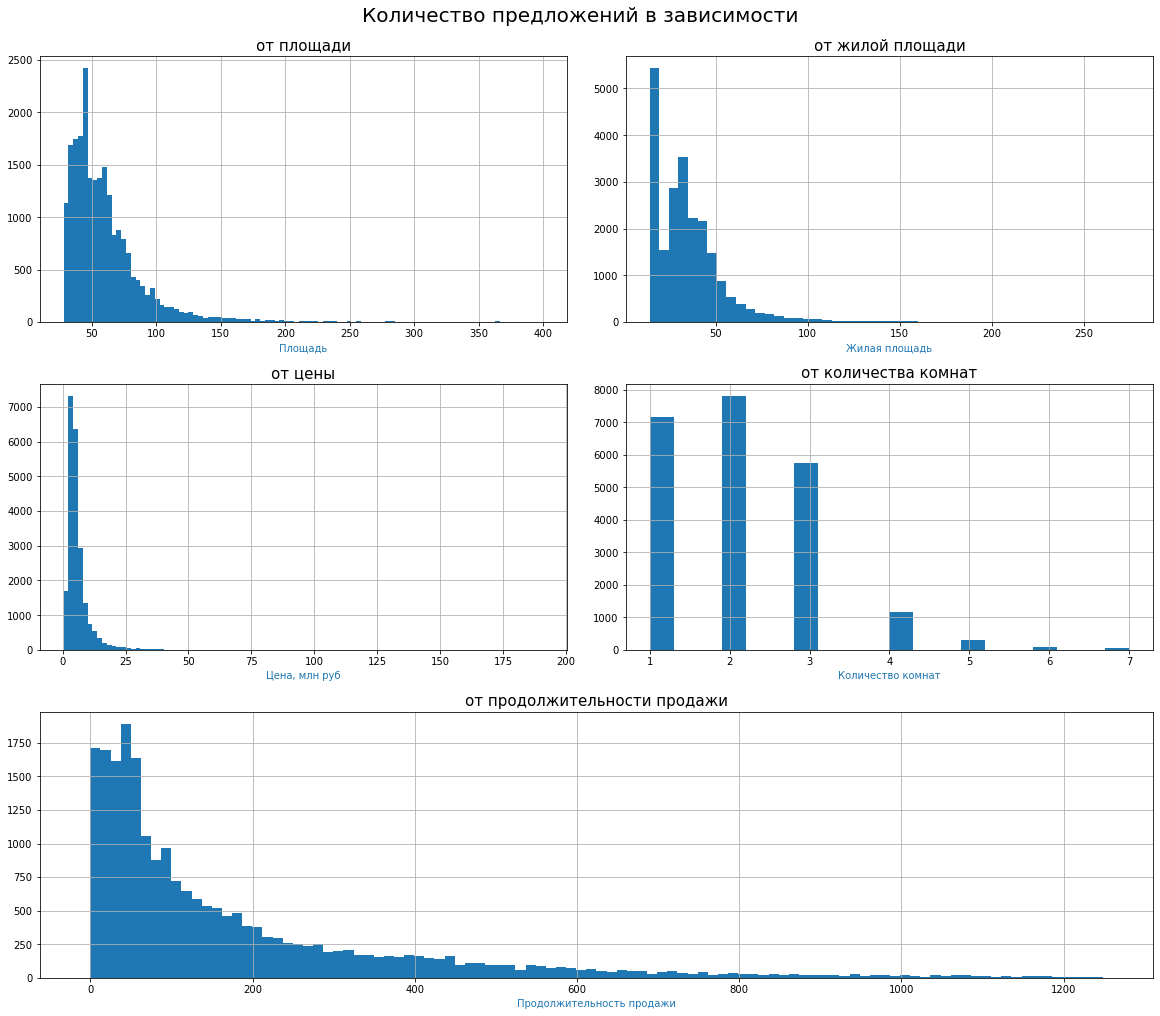

In [65]:
fig = plt.figure(constrained_layout=True, figsize=(16,14))

gs = GridSpec(3, 2, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, :])


x0 = df['total_area']
x1 = df['living_area']
x2 = df['last_price_mln']
x3 = df['number_of_rooms']
x4 = df['days_expositioned']

#  график по площади
ax0.hist(x0, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax0.set_xlabel('Площадь', fontsize=10, color='tab:blue')
ax0.set_title('от площади', fontsize=15)
ax0.grid(True)

# график по высоте потолка
ax1.hist(x1, 50, facecolor='tab:blue', alpha=1, label='Вся область')
ax1.set_xlabel('Жилая площадь', fontsize=10, color='tab:blue')
ax1.set_title('от жилой площади', fontsize=15)
ax1.grid(True)

#  график по цене
ax2.hist(x2, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax2.set_xlabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.set_title('от цены', fontsize=15)
ax2.grid(True)

#  график по комнатам
ax3.hist(x3, 20, facecolor='tab:blue', alpha=1, label='Вся область')
ax3.set_xlabel('Количество комнат', fontsize=10, color='tab:blue')
ax3.set_title('от количества комнат', fontsize=15)
ax3.grid(True)


# график по времени продажи
ax4.hist(x4, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax4.set_xlabel('Продолжительность продажи', fontsize=10, color='tab:blue')
ax4.set_title('от продолжительности продажи', fontsize=15)
ax4.grid(True)

fig.suptitle('Количество предложений в зависимости', fontsize=20)
plt.show()

А теперь взглянем на гистограмму по продолжительности продажи, кажется у нас тут оказалось два интересных пика &mdash; на 45 и 60 днях. Немного ~гуглежа~ яндекшения привело нас к этой [странице](https://yandex.ru/support/realty/paid.html#paid__duration), наиболее вероятно что подобная ситуация и является причиной такой активности именно в эти дни. То есть на этом сервисе сроки бесплатных объявлений каким-то образом связаны с 45 и 60 днями.

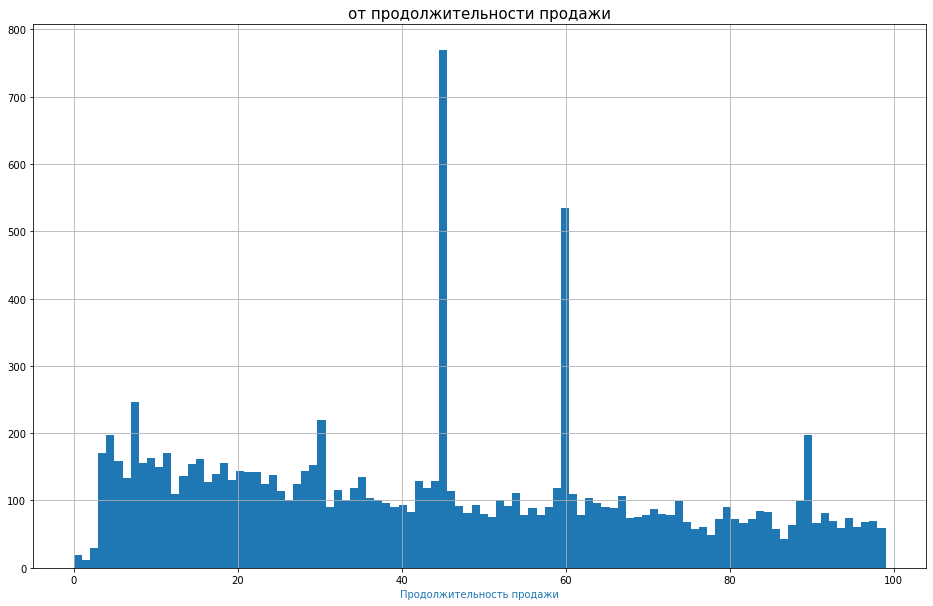

In [66]:
fig, ax = plt.subplots(figsize=(16,10))

x = df.loc[df['days_expositioned'] < 100]['days_expositioned']

# график по времени продажи
ax.hist(x, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax.set_xlabel('Продолжительность продажи', fontsize=10, color='tab:blue')
ax.set_title('от продолжительности продажи', fontsize=15)
ax.grid(True)

#fig.suptitle('Количество предложений в зависимости', fontsize=20)
plt.show()

Если наша теория верна, то эти два дня имеют наибольший потенциал в части появления дубликатов, поэтому стоит немного почистить эти два дня.

In [67]:
df.loc[(df['days_expositioned'] == 45) | (df['days_expositioned'] == 60)]

,first_expositioned,first_expositioned_weekday,first_expositioned_month,first_expositioned_year,days_expositioned,total_images,last_price,last_price_mln,square_meter_price,number_of_rooms,total_area,living_area,living_to_total_area,kitchen_area,kitchen_to_total_area,ceiling_height,number_of_balconies,floor,floors_total,floor_type,is_studio,is_open_plan,is_apartment,locality_id,city_center_distance,parks_3km_radius,ponds_3km_radius
22,2017-04-24,0,4,2017,60,20,5000000,5.00,86206,2,58.0,30.00,0.52,11.00,0.19,2.750000,2,15,25,2,False,False,NaN,106,29,0,0
78,2018-02-22,3,2,2018,45,9,4350000,4.35,117567,1,37.0,18.00,0.49,10.70,0.29,2.775725,0,6,19,2,False,False,NaN,224,15,0,0
82,2018-01-15,0,1,2018,60,3,4500000,4.50,55900,3,80.5,55.29,0.69,10.88,0.14,3.013759,0,16,25,2,False,False,NaN,299,19,0,0
89,2018-10-25,3,10,2018,45,9,2500000,2.50,39682,3,63.0,43.00,0.68,9.00,0.14,2.500000,0,4,5,2,False,False,NaN,239,29,0,0
105,2018-01-07,6,1,2018,60,12,4900000,4.90,153125,1,32.0,15.00,0.47,9.00,0.28,2.731267,0,5,25,2,False,False,NaN,224,16,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23621,2017-08-31,3,8,2017,60,11,5000000,5.00,131926,1,37.9,18.90,0.50,8.30,0.22,2.600000,1,14,21,2,False,False,NaN,224,14,0,0
23635,2018-10-26,4,10,2018,60,9,5100000,5.10,141666,1,36.0,18.00,0.50,8.00,0.22,2.800000,0,11,15,2,False,False,NaN,224,12,0,1
23642,2018-07-03,1,7,2018,60,14,5950000,5.95,74097,3,80.3,55.15,0.69,11.76,0.15,2.700000,0,5,12,2,False,False,NaN,89,34,0,2
23670,2018-02-08,3,2,2018,45,9,2450000,2.45,53728,1,45.6,31.32,0.69,6.73,0.15,2.800000,0,2,9,2,False,False,NaN,241,29,0,0


Всего в эти два дня закрылось 1299 объявлений &mdash; невероятный успех (или вероятная экономность). Попробуем избавиться от дубликатов, для этого нам необходимо аккуратно выбрать характеристики. С одной стороны, их набор должен давать определенную степень уникальности, с другой &mdash; каждая из них должна быть стабильной и, желательно, целочисленной, а не дробной. Для этого мы выбрали следующие значения: `number_of_balconies`, `city_center_distance`, `floor`, `locality_id`. Этот набор достаточно разноплановый, что даёт достаточную степень уникальности, при этом состоит из столбцов с целочисленными значениями, то есть экономный владелец не сможет изменить эти значения на десятую чтобы добавить уникальности, и при этом вряд ли станет менять эти значения так как несоответствия окажутся ему не выгодны и будут довольно очевидны.

In [68]:
repeaters = df.loc[(df['days_expositioned'] == 45) | (df['days_expositioned'] == 60)]
rep_index = repeaters.loc[repeaters.duplicated(subset=['number_of_balconies', 'city_center_distance', 'floor', 'locality_id'], keep=False)].index

try:
    df.drop(rep_index, axis=0, inplace=True)
except:
    print('Ошибка!')
finally:
    display(df.loc[(df['days_expositioned'] == 45) | (df['days_expositioned'] == 60)])

,first_expositioned,first_expositioned_weekday,first_expositioned_month,first_expositioned_year,days_expositioned,total_images,last_price,last_price_mln,square_meter_price,number_of_rooms,total_area,living_area,living_to_total_area,kitchen_area,kitchen_to_total_area,ceiling_height,number_of_balconies,floor,floors_total,floor_type,is_studio,is_open_plan,is_apartment,locality_id,city_center_distance,parks_3km_radius,ponds_3km_radius
22,2017-04-24,0,4,2017,60,20,5000000,5.00,86206,2,58.0,30.00,0.52,11.00,0.19,2.750000,2,15,25,2,False,False,NaN,106,29,0,0
82,2018-01-15,0,1,2018,60,3,4500000,4.50,55900,3,80.5,55.29,0.69,10.88,0.14,3.013759,0,16,25,2,False,False,NaN,299,19,0,0
89,2018-10-25,3,10,2018,45,9,2500000,2.50,39682,3,63.0,43.00,0.68,9.00,0.14,2.500000,0,4,5,2,False,False,NaN,239,29,0,0
110,2017-09-29,4,9,2017,45,6,3850000,3.85,53250,2,72.3,27.40,0.38,23.60,0.33,2.980861,0,2,3,2,False,False,NaN,184,29,0,0
143,2016-06-08,2,6,2016,60,9,2990000,2.99,99666,1,30.0,20.00,0.67,5.60,0.19,2.500000,0,9,9,3,False,False,NaN,224,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23613,2018-03-04,6,3,2018,45,4,3950000,3.95,75961,3,52.0,35.71,0.69,5.82,0.11,2.879938,0,2,5,2,False,False,NaN,171,22,0,0
23621,2017-08-31,3,8,2017,60,11,5000000,5.00,131926,1,37.9,18.90,0.50,8.30,0.22,2.600000,1,14,21,2,False,False,NaN,224,14,0,0
23642,2018-07-03,1,7,2018,60,14,5950000,5.95,74097,3,80.3,55.15,0.69,11.76,0.15,2.700000,0,5,12,2,False,False,NaN,89,34,0,2
23670,2018-02-08,3,2,2018,45,9,2450000,2.45,53728,1,45.6,31.32,0.69,6.73,0.15,2.800000,0,2,9,2,False,False,NaN,241,29,0,0


Отлично, мы избавились от половины подобных значений. Теперь взглянем на график:

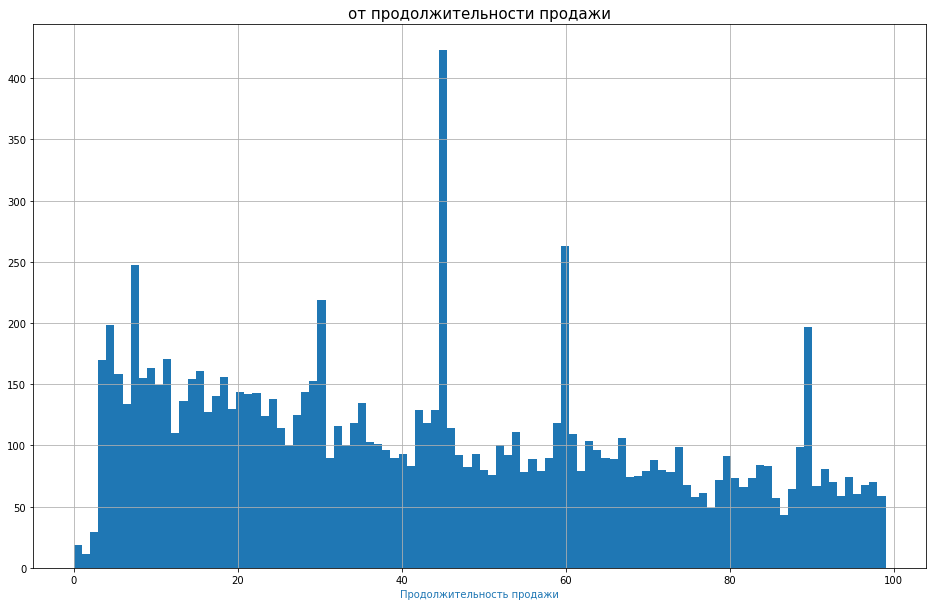

In [69]:
fig, ax = plt.subplots(figsize=(16,10))

x = df.loc[df['days_expositioned'] < 100]['days_expositioned']

# график по времени продажи
ax.hist(x, 100, facecolor='tab:blue', alpha=1, label='Вся область')
ax.set_xlabel('Продолжительность продажи', fontsize=10, color='tab:blue')
ax.set_title('от продолжительности продажи', fontsize=15)
ax.grid(True)

#fig.suptitle('Количество предложений в зависимости', fontsize=20)
plt.show()

Да, пики на эти дни всё еще есть и они заметны. Однако, они уменьшились практически в два раза. Кроме того, если эти дни являются сроками для выставления бесплатных объявлений, то появление этих пиковых значений абсолютно закономерно.

Отлично, графики выглядят куда опрятнее, от выбивающихся и редких значений мы избавились.

[к началу шага](#4-2) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-3"></a>
### Шаг 4.3 Какие факторы больше всего влияют на стоимость квартиры?

Теперь рассмотрим как разные факторы влияют на стоимость квартиры. Построим графики зависимостей:

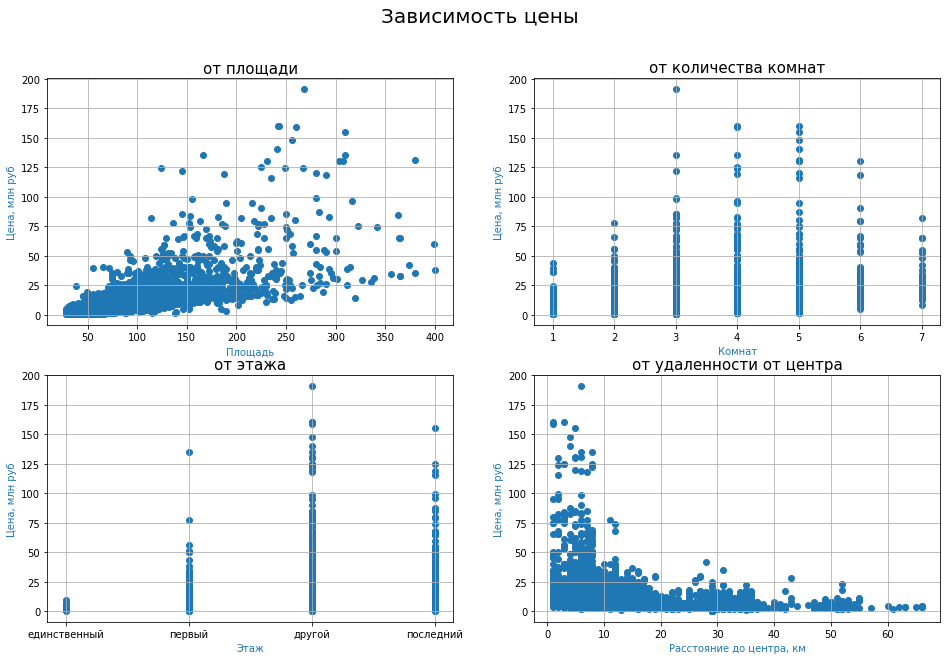

In [70]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10))
x0 = df['total_area']
x1 = df['number_of_rooms']
x2 = df['floor_type']
x3 = df['city_center_distance']
y = df['last_price_mln']

#  график по площади
ax0.scatter(x0, y, c='tab:blue')
ax0.set_xlabel('Площадь', fontsize=10, color='tab:blue')
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.set_title('от площади', fontsize=15)
ax0.grid(True)

#  график по комнатам
ax1.scatter(x1, y, c='tab:blue')
ax1.set_title('от количества комнат', fontsize=15)
ax1.set_xlabel('Комнат', fontsize=10, color='tab:blue')
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid(True)

#  график по этажам
ax2.scatter(x2, y, c='tab:blue')
ax2.set_title('от этажа', fontsize=15)
ax2.set_xlabel('Этаж', fontsize=10, color='tab:blue')
ax2.set_xticks([0, 1, 2, 3]) 
ax2.set_xticklabels(['единственный', 'первый', 'другой', 'последний'])
ax2.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.grid(True)

# график по удаленности от центра
ax3.scatter(x3, y, c='tab:blue')
ax3.set_title('от удаленности от центра', fontsize=15)
ax3.set_xlabel('Расстояние до центра, км', fontsize=10, color='tab:blue')
ax3.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax3.grid(True)

fig.suptitle('Зависимость цены', fontsize=20)
plt.show()

И в другом формате:

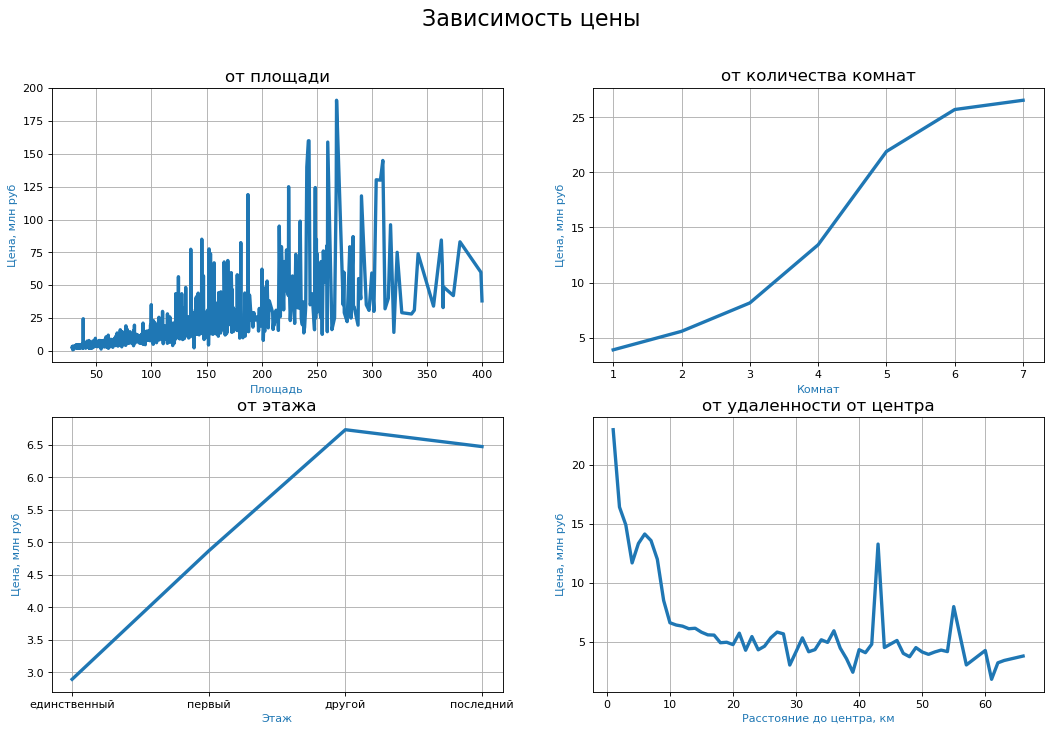

In [71]:
area_df_pivot = df.pivot_table(index='total_area', values='last_price_mln', aggfunc=['mean'])
rooms_df_pivot = df.pivot_table(index='number_of_rooms', values='last_price_mln', aggfunc=['mean'])
floor_df_pivot = df.pivot_table(index='floor_type', values='last_price_mln', aggfunc=['mean'])
center_df_pivot = df.pivot_table(index='city_center_distance', values='last_price_mln', aggfunc=['mean'])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10), dpi=80)

x0 = area_df_pivot.index
x1 = rooms_df_pivot.index
x2 = floor_df_pivot.index
x3 = center_df_pivot.index

y0 = area_df_pivot[('mean', 'last_price_mln')]
y1 = rooms_df_pivot[('mean', 'last_price_mln')]
y2 = floor_df_pivot[('mean', 'last_price_mln')]
y3 = center_df_pivot[('mean', 'last_price_mln')]

#  график по площади
ax0.plot(x0, y0, c='tab:blue', linewidth=3)
ax0.set_xlabel('Площадь', fontsize=10, color='tab:blue')
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.set_title('от площади', fontsize=15)
ax0.grid(True)

#  график по комнатам
ax1.plot(x1, y1, c='tab:blue', linewidth=3)
ax1.set_title('от количества комнат', fontsize=15)
ax1.set_xlabel('Комнат', fontsize=10, color='tab:blue')
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid(True)

#  график по этажам
ax2.plot(x2, y2, c='tab:blue', linewidth=3)
ax2.set_title('от этажа', fontsize=15)
ax2.set_xlabel('Этаж', fontsize=10, color='tab:blue')
ax2.set_xticks([0, 1, 2, 3]) 
ax2.set_xticklabels(['единственный', 'первый', 'другой', 'последний'])
ax2.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.grid(True)

# график по удаленности от центра
ax3.plot(x3, y3, c='tab:blue', linewidth=3)
ax3.set_title('от удаленности от центра', fontsize=15)
ax3.set_xlabel('Расстояние до центра, км', fontsize=10, color='tab:blue')
ax3.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax3.grid(True)

fig.suptitle('Зависимость цены', fontsize=20)
plt.show()

Как видим, зависимость цены от площади очень заметная, легко можно провести линию тренда с условными коридорами. Но в целом, при прочих равных ожидаем, что чем больше площадь, тем дороже квартира.

С количеством комнат ситуация чуть другая: вплоть до 5 комнат цена довольно быстро растёт, а после 5 начинается двоякая ситуация. С одной стороны, средняя цена намного медленнее, но растёт, с другой стороны максимальные значения по стоимости представленны именно среди пятикомнатных квартир.

Зависимость от этажа тоже интересная, наиболее дорогими считаются промежуточные этажи, почти сразу за ними верхние этажи (возможно за счет пентхаусов), самыми экономными (что логично) считаются первые этажи, однако даже они оказались дороже, чем предложения в одноэтажных домах.

Удаленность от центра также влияет на стоимость: на 10 километрах явно виден переход от резкого падения стоимости к пологому. После 40-го и 50-го километра наблюдаются резкие скачки средней цены (вероятно влияние загородной элитной недвижимости).

Теперь посмотрим на графики для времени продажи:

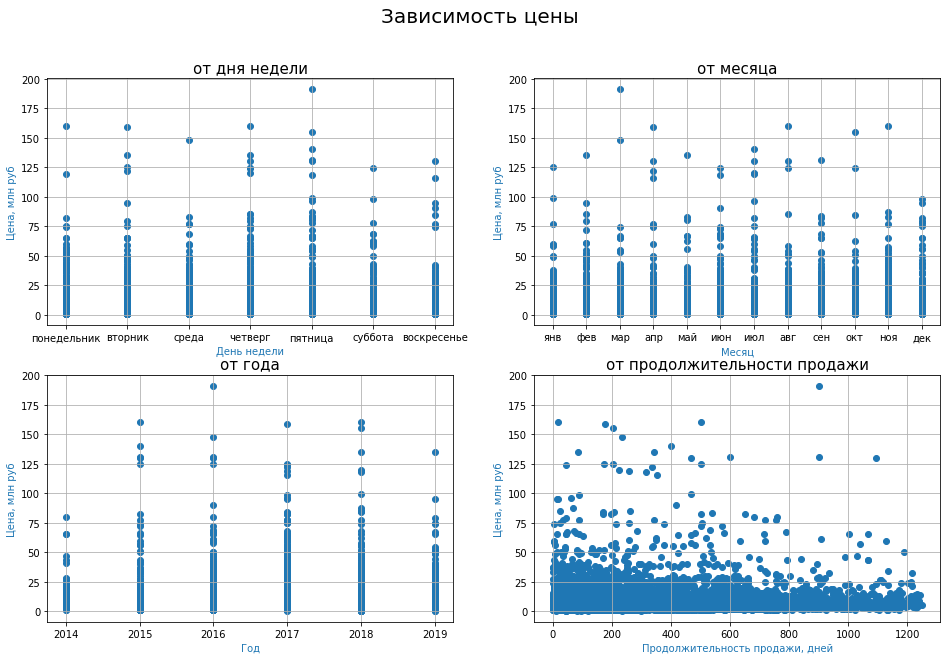

In [72]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10))
x0 = df['first_expositioned_weekday']
x1 = df['first_expositioned_month']
x2 = df['first_expositioned_year']
x3 = df['days_expositioned']
y = df['last_price_mln']

#  график по дням недели
ax0.scatter(x0, y)
ax0.set_title('от дня недели', fontsize=15)
ax0.set_xlabel('День недели', fontsize=10, color='tab:blue')
ax0.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax0.set_xticklabels(['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.grid(True)

#  график по месяцам
ax1.scatter(x1, y)
ax1.set_title('от месяца', fontsize=15)
ax1.set_xlabel('Месяц', fontsize=10, color='tab:blue')
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_xticklabels(['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.grid(True)

#  график по годам
ax2.scatter(x2, y)
ax2.set_title('от года', fontsize=15)
ax2.set_xlabel('Год', fontsize=10, color='tab:blue')
ax2.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.grid(True)

# график по продолжительности продажи
ax3.scatter(x3, y)
ax3.set_title('от продолжительности продажи', fontsize=15)
ax3.set_xlabel('Продолжительность продажи, дней', fontsize=10, color='tab:blue')
ax3.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax3.grid(True)

fig.suptitle('Зависимость цены', fontsize=20)
plt.show()

И в другой форме:

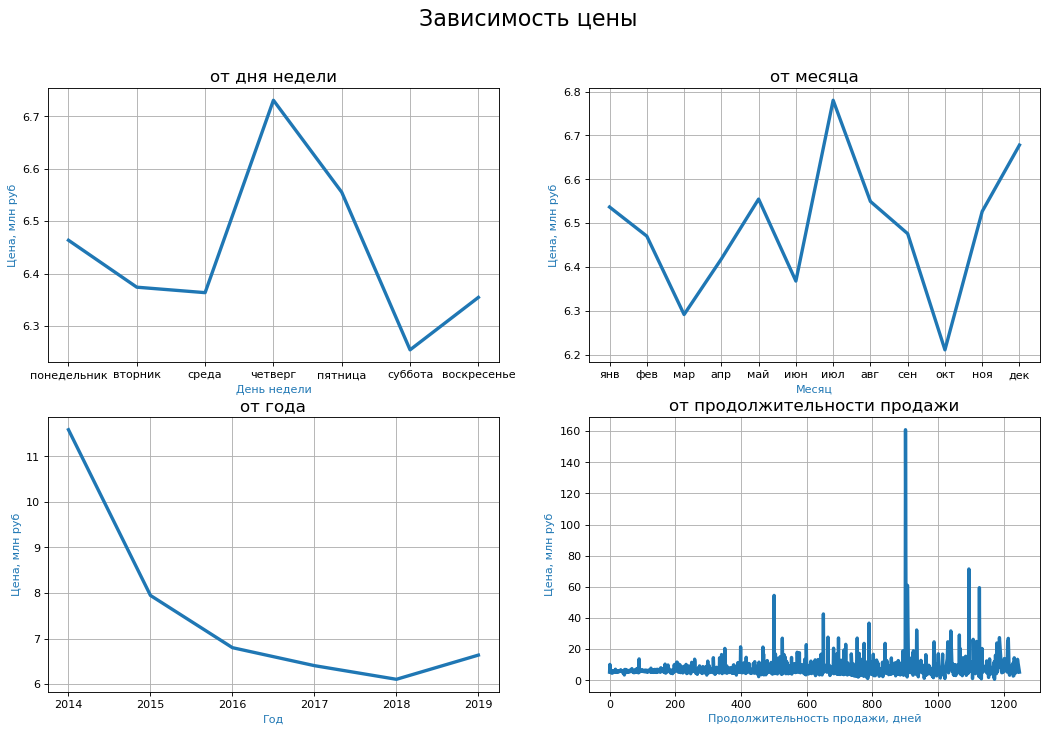

In [73]:
weekday_df_pivot = df.pivot_table(index='first_expositioned_weekday', values='last_price_mln', aggfunc=['mean'])
month_df_pivot = df.pivot_table(index='first_expositioned_month', values='last_price_mln', aggfunc=['mean'])
year_df_pivot = df.pivot_table(index='first_expositioned_year', values='last_price_mln', aggfunc=['mean'])
days_df_pivot = df.pivot_table(index='days_expositioned', values='last_price_mln', aggfunc=['mean'])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10), dpi=80)

x0 = weekday_df_pivot.index
x1 = month_df_pivot.index
x2 = year_df_pivot.index
x3 = days_df_pivot.index

y0 = weekday_df_pivot[('mean', 'last_price_mln')]
y1 = month_df_pivot[('mean', 'last_price_mln')]
y2 = year_df_pivot[('mean', 'last_price_mln')]
y3 = days_df_pivot[('mean', 'last_price_mln')]

#  график по дням недели
ax0.plot(x0, y0, c='tab:blue', linewidth=3)
ax0.set_xlabel('День недели', fontsize=10, color='tab:blue')
ax0.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax0.set_xticklabels(['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.set_title('от дня недели', fontsize=15)
ax0.grid(True)

#  график по месяцам
ax1.plot(x1, y1, c='tab:blue', linewidth=3)
ax1.set_title('от месяца', fontsize=15)
ax1.set_xlabel('Месяц', fontsize=10, color='tab:blue')
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_xticklabels(['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.grid(True)

#  график по годам
ax2.plot(x2, y2, c='tab:blue', linewidth=3)
ax2.set_title('от года', fontsize=15)
ax2.set_xlabel('Год', fontsize=10, color='tab:blue')
ax2.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.grid(True)

# график по продолжительности продажи
ax3.plot(x3, y3, c='tab:blue', linewidth=3)
ax3.set_title('от продолжительности продажи', fontsize=15)
ax3.set_xlabel('Продолжительность продажи, дней', fontsize=10, color='tab:blue')
ax3.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax3.grid(True)

fig.suptitle('Зависимость цены', fontsize=20)
plt.show()

В случае даты объявления и продолжительности продажи графики средних более явные.

Если в случае точечного графика видно только что объявления по выходным оказываются слегка дешевле, то на графике средних видна интересная линия: наиболее дорогие объявления появляются в четверг, а самые дешёвые &mdash; в субботу, при этом в выходные стоимость выставляемых квартир заметно ниже, чем в будни.

Если мы посмотрим на первый график зависимости от года, то может сложиться впечателние, что цены росли до 2016 года, а потом слегка начали снижаться. Но на втором графике видно, что средняя цена была максимальной в 2014 году, а затем до 2018 года значительно снизилась. В 2019 году произошёл небольшой рост примерно до уровня 2016-2017 годов.

Если смотреть на месяц выставления объявления, то наиболее дорогим оказался июль, а самым дешёвым - октябрь. Занимательно, что между июлем и октябрём примерно 90 дней &mdash; это близко к медианному значению срока продажи квартиры. В целом, если не обращать внимание на пиковые значения, то в конце года цены слегка выше, чем в начале.

Продолжительность продажи скорее влияет на цену не линейно, напротив, цена становится более хаотичной и неопределённой, может как вырасти с течением времени, так и наоборот упасть. Однако, наиболее вероятно, что цена снизится. При этом на графике видны пики на достаточно больших сроках &mdash; вероятно это связано с тем, что дорогая недвижимость медленнее оборачивается.

Теперь выберем 10 населённых пунктов с наибольшим количеством объявлений и отсортируем их по убыванию цены:

In [74]:
locality_pivot = df.pivot_table(index='locality_id', values='square_meter_price', aggfunc=['count', 'mean'])
top10_locs = locality_pivot.nlargest(10, ('count', 'square_meter_price')).sort_values(('mean', 'square_meter_price'), ascending=False)
top10_locs[('mean', 'square_meter_price')] = top10_locs[('mean', 'square_meter_price')].round(2)
top10_locs['locality_name'] = top10_locs.index.map(locality_dict)
top10_locs

,count,mean,locality_name
,square_meter_price,square_meter_price,
locality_id,,,
224,14539,113877.42,Санкт-Петербург
203,353,103223.67,Пушкин
106,402,94651.32,Кудрово
171,294,89409.76,Парголово
147,462,84386.54,Мурино
299,409,77443.97,Шушары
89,319,75506.87,Колпино
43,284,68988.39,Гатчина


Видим, что наиболее выделяются города Санкт-Петербург и Пушкин (больше 100 000 за кв м). Кудрово, Парголово и Мурино держатся слегка позади. Остальные города расположены ниже и кучнее в плане цены, и не отличаются между собой так кардинально как от этих двух групп городов.

[к началу шага](#4-3) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-4"></a>
### Шаг 4.4 Как цена зависит от удалённости от центра?

Теперь более подробно ознакомимся с зависимостью цены от удалённости от центра. Для начала построим сводную таблицу с максимальным, срадним, медианным и минимальными значениями цены в зависимости от расстояния до центра. А затем построим два графика на основе сводной таблицы (на втором графике убрано максимальное значение для наглядности):

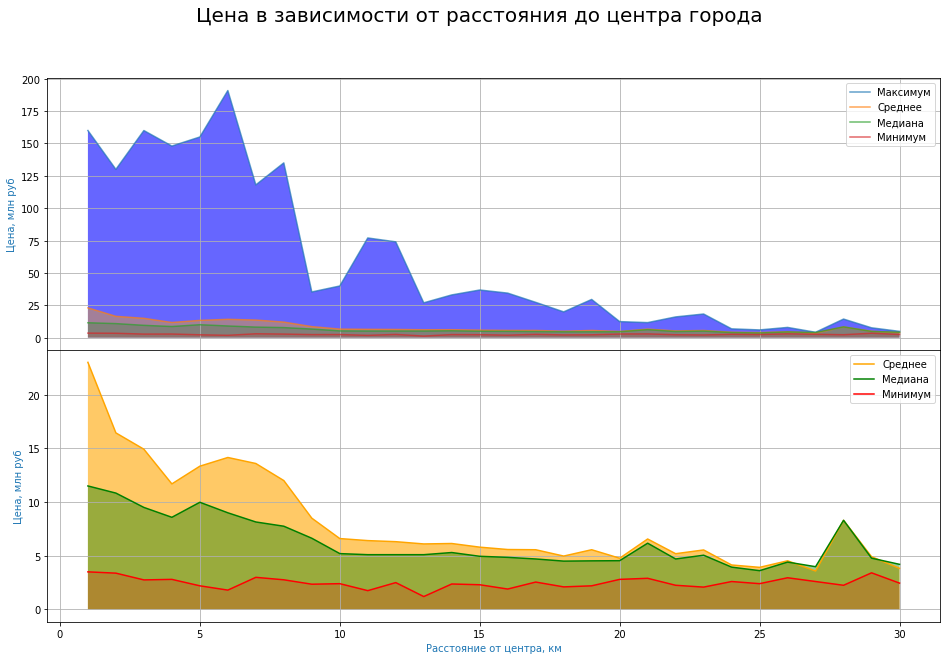

In [75]:
df_spb = df.query('locality_id == 224')
spb_pivot = df_spb.pivot_table(index='city_center_distance', values='last_price_mln', aggfunc=['max', 'mean', 'median', 'min'])
spb_pivot[('mean', 'last_price_mln')] = spb_pivot[('mean', 'last_price_mln')].round(2)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(16,10))
fig.subplots_adjust(hspace=0)
fig.suptitle('Цена в зависимости от расстояния до центра города', fontsize=20)

x = spb_pivot.index
y0 = spb_pivot[('max', 'last_price_mln')]
y1 = spb_pivot[('mean', 'last_price_mln')]
y2 = spb_pivot[('median', 'last_price_mln')]
y3 = spb_pivot[('min', 'last_price_mln')]

ax0.plot(x, y0, x, y1, x, y2, x, y3, alpha=.7)
ax0.set_xlabel('Расстояние от центра, км', fontsize=10, color='tab:blue')
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.fill_between(x, y0, facecolor='blue', interpolate=True, alpha=.6)
ax0.fill_between(x, y1, facecolor='orange', interpolate=True, alpha=.4)
ax0.fill_between(x, y2, facecolor='green', interpolate=True, alpha=.2)
ax0.fill_between(x, y3, facecolor='red', interpolate=True, alpha=.1)
ax0.grid(True)
ax0.legend(['Максимум', 'Среднее', 'Медиана', 'Минимум'], fontsize=10)

ax1.plot(x, y1, color='orange')
ax1.plot(x, y2, color='green')
ax1.plot(x, y3, color='red')
ax1.set_xlabel('Расстояние от центра, км', fontsize=10, color='tab:blue')
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.fill_between(x, y1, facecolor='orange', interpolate=True, alpha=.6)
ax1.fill_between(x, y2, facecolor='green', interpolate=True, alpha=.4)
ax1.fill_between(x, y3, facecolor='red', interpolate=True, alpha=.2)
ax1.grid(True)
ax1.legend(['Среднее', 'Медиана', 'Минимум'], fontsize=10)

plt.show()

Взглянув на график видим, что пиковое значение находится на расстоянии 6 км от центра, после этого максимальная цена заметно ниже. На расстоянии 5 км от центра начинает заметно снижаться медианное значение, а на расстоянии 6 км - среднее.
Поэтому, на основании этой информации будем считать, что центр &mdash; это всё, что расположено не далее чем в 6 километрах от центральной точки.

In [76]:
spb_center = df_spb.query('city_center_distance <= 6')
spb = df_spb.query('locality_id == 224')

[к началу шага](#4-4) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-5"></a>
### Шаг 4.5 Сегмент квартир в центре: отклоняются ли они от общих показателей по всему городу?

Теперь оценим такие показатели как площадь, цена, число комнат, высота потолков. Кроме того, мы сравним как эти показатели соотносятся от общих показателей по всему городу.

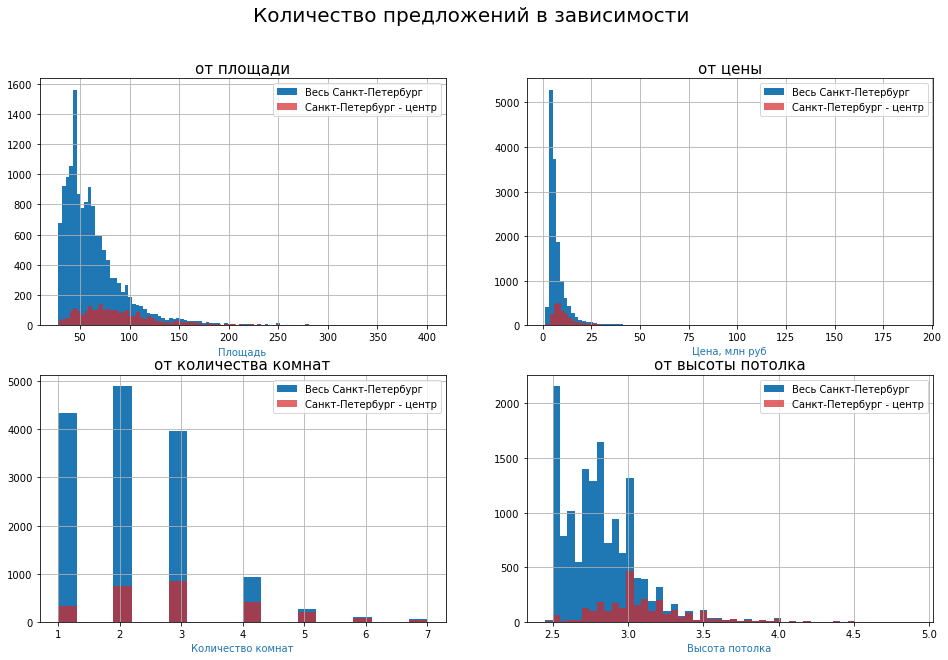

In [77]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10))
x0, a0 = spb_center['total_area'], spb['total_area']
x1, a1 = spb_center['last_price_mln'], spb['last_price_mln']
x2, a2 = spb_center['number_of_rooms'], spb['number_of_rooms']
x3, a3 = spb_center['ceiling_height'], spb['ceiling_height']

#  график по площади
ax0.hist(a0, 100, facecolor='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax0.hist(x0, 100, facecolor='tab:red', alpha=.7, label='Санкт-Петербург - центр')
ax0.set_xlabel('Площадь', fontsize=10, color='tab:blue')
ax0.set_title('от площади', fontsize=15)
ax0.legend()
ax0.grid(True)

#  график по комнатам
ax1.hist(a1, 100, facecolor='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax1.hist(x1, 100, facecolor='tab:red', alpha=.7, label='Санкт-Петербург - центр')
ax1.set_xlabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.set_title('от цены', fontsize=15)
ax1.legend()
ax1.grid(True)

#  график по этажам
ax2.hist(a2, 20, facecolor='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax2.hist(x2, 20, facecolor='tab:red', alpha=.7, label='Санкт-Петербург - центр')
ax2.set_xlabel('Количество комнат', fontsize=10, color='tab:blue')
ax2.set_title('от количества комнат', fontsize=15)
ax2.legend()
ax2.grid(True)

# график по удаленности от центра
ax3.hist(a3, 50, facecolor='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax3.hist(x3, 50, facecolor='tab:red', alpha=.7, label='Санкт-Петербург - центр')
ax3.set_xlabel('Высота потолка', fontsize=10, color='tab:blue')
ax3.set_title('от высоты потолка', fontsize=15)
ax3.legend()
ax3.grid(True)

fig.suptitle('Количество предложений в зависимости', fontsize=20)
plt.show()

Видим что центр Санкт-Петербурга представляет из себя особенный сегмент. При том что в целом доля предложения на рынке у центра небольшая, в части дорогой и элитной недвижимости центр является основным поставщиком предложений.

По площади &mdash; на площадях до 100 кв м имеет малую долю, на площадях свыше 100 кв м занимает больше половины рынка.

По количеству комнат &mdash; малая доля в предложении 1-3 комнатных квартир, примерно треть в 4-комнатных, для б***о***льших квартир почти полностью занимает рынок

По цене &mdash; начиная с 10 млн рублей практически всё предложение находится в центре города.

По высоте потолка &mdash; треть трёхметровых потолков находятся в центре, малая доля от предложения потолков ниже 3 метров. Потолки выше 3 метров практически всегда в центре.

Теперь сравним центр со всем городом по другим показателям:

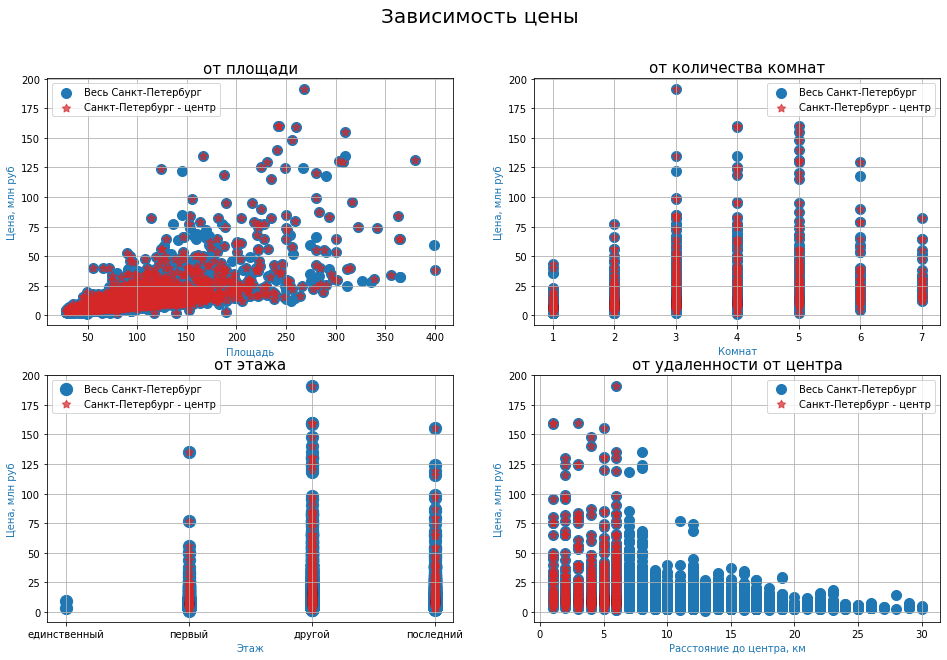

In [78]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10))
x0, a0 = spb_center['total_area'], spb['total_area']
x1, a1 = spb_center['number_of_rooms'], spb['number_of_rooms']
x2, a2 = spb_center['floor_type'], spb['floor_type']
x3, a3 = spb_center['city_center_distance'], spb['city_center_distance']
y, b = spb_center['last_price_mln'], spb['last_price_mln']

#  график по площади
ax0.scatter(a0, b, s=100, c='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax0.scatter(x0, y, s=75, c='tab:red', alpha=.7, label='Санкт-Петербург - центр', marker=(5, 1))
ax0.set_xlabel('Площадь', fontsize=10, color='tab:blue')
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.set_title('от площади', fontsize=15)
ax0.legend()
ax0.grid(True)

#  график по комнатам
ax1.scatter(a1, b, s=100, c='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax1.scatter(x1, y, s=75, c='tab:red', alpha=.7, label='Санкт-Петербург - центр', marker=(5, 1))
ax1.set_title('от количества комнат', fontsize=15)
ax1.set_xlabel('Комнат', fontsize=10, color='tab:blue')
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.legend()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid(True)

#  график по этажам
ax2.scatter(a2, b, s=150, c='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax2.scatter(x2, y, s=75, c='tab:red', alpha=.7, label='Санкт-Петербург - центр', marker=(5, 1))
ax2.set_title('от этажа', fontsize=15)
ax2.set_xlabel('Этаж', fontsize=10, color='tab:blue')
ax2.set_xticks([0, 1, 2, 3]) 
ax2.set_xticklabels(['единственный', 'первый', 'другой', 'последний'])
ax2.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.legend()
ax2.grid(True)

# график по удаленности от центра
ax3.scatter(a3, b, s=100, c='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax3.scatter(x3, y, s=75, c='tab:red', alpha=.7, label='Санкт-Петербург - центр', marker=(5, 1))
ax3.set_title('от удаленности от центра', fontsize=15)
ax3.set_xlabel('Расстояние до центра, км', fontsize=10, color='tab:blue')
ax3.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax3.legend()
ax3.grid(True)

fig.suptitle('Зависимость цены', fontsize=20)
plt.show()

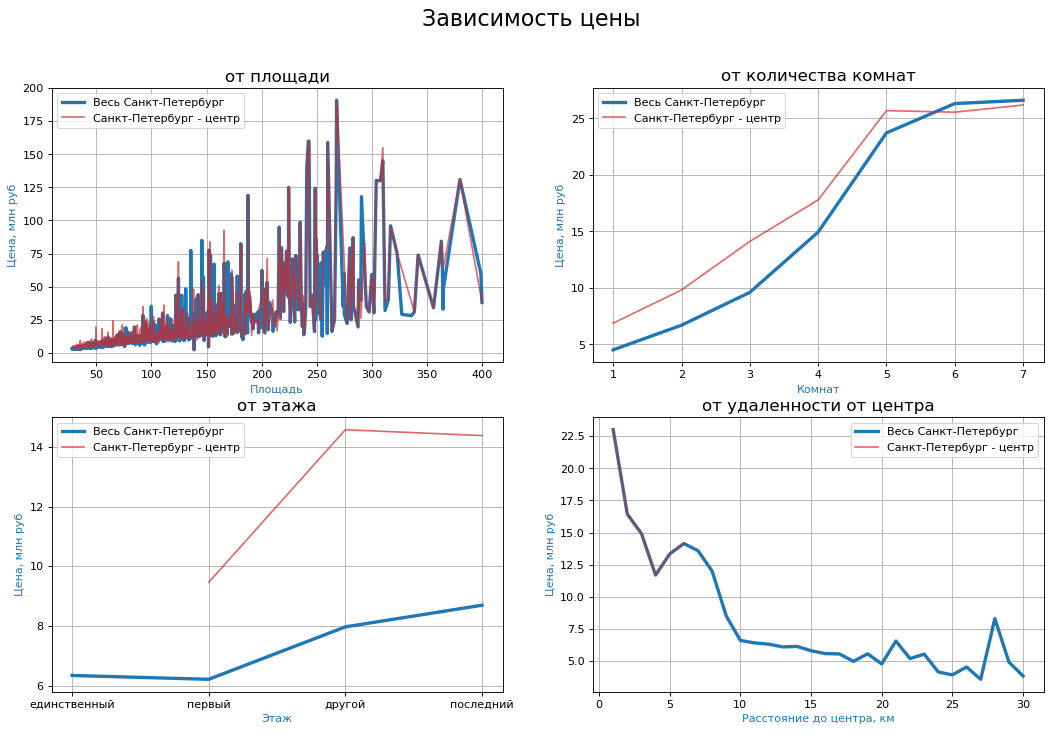

In [79]:
area_spb_pivot = spb.pivot_table(index='total_area', values='last_price_mln', aggfunc=['mean'])
rooms_spb_pivot = spb.pivot_table(index='number_of_rooms', values='last_price_mln', aggfunc=['mean'])
floor_spb_pivot = spb.pivot_table(index='floor_type', values='last_price_mln', aggfunc=['mean'])
center_spb_pivot = spb.pivot_table(index='city_center_distance', values='last_price_mln', aggfunc=['mean'])

area_spb_center_pivot = spb_center.pivot_table(index='total_area', values='last_price_mln', aggfunc=['mean'])
rooms_spb_center_pivot = spb_center.pivot_table(index='number_of_rooms', values='last_price_mln', aggfunc=['mean'])
floor_spb_center_pivot = spb_center.pivot_table(index='floor_type', values='last_price_mln', aggfunc=['mean'])
center_spb_center_pivot = spb_center.pivot_table(index='city_center_distance', values='last_price_mln', aggfunc=['mean'])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10), dpi=80)

x0, x1 = area_spb_pivot.index, area_spb_center_pivot.index
x2, x3 = rooms_spb_pivot.index, rooms_spb_center_pivot.index
x4, x5 = floor_spb_pivot.index, floor_spb_center_pivot.index
x6, x7 = center_spb_pivot.index, center_spb_center_pivot.index

y0, y1 = area_spb_pivot[('mean', 'last_price_mln')], area_spb_center_pivot[('mean', 'last_price_mln')]
y2, y3 = rooms_spb_pivot[('mean', 'last_price_mln')], rooms_spb_center_pivot[('mean', 'last_price_mln')]
y4, y5 = floor_spb_pivot[('mean', 'last_price_mln')], floor_spb_center_pivot[('mean', 'last_price_mln')]
y6, y7 = center_spb_pivot[('mean', 'last_price_mln')], center_spb_center_pivot[('mean', 'last_price_mln')]

#  график по площади
ax0.plot(x0, y0, c='tab:blue', linewidth=3)
ax0.plot(x1, y1, c='tab:red', alpha=.7)
ax0.set_xlabel('Площадь', fontsize=10, color='tab:blue')
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.set_title('от площади', fontsize=15)
ax0.legend(['Весь Санкт-Петербург', 'Санкт-Петербург - центр'])
ax0.grid(True)

#  график по комнатам
ax1.plot(x2, y2, c='tab:blue', linewidth=3)
ax1.plot(x3, y3, c='tab:red', alpha=.7)
ax1.set_title('от количества комнат', fontsize=15)
ax1.set_xlabel('Комнат', fontsize=10, color='tab:blue')
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.legend(['Весь Санкт-Петербург', 'Санкт-Петербург - центр'])
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid(True)

#  график по этажам
ax2.plot(x4, y4, c='tab:blue', linewidth=3)
ax2.plot(x5, y5, c='tab:red', alpha=.7)
ax2.set_title('от этажа', fontsize=15)
ax2.set_xlabel('Этаж', fontsize=10, color='tab:blue')
ax2.set_xticks([0, 1, 2, 3]) 
ax2.set_xticklabels(['единственный', 'первый', 'другой', 'последний'])
ax2.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.legend(['Весь Санкт-Петербург', 'Санкт-Петербург - центр'])
ax2.grid(True)

# график по удаленности от центра
ax3.plot(x6, y6, c='tab:blue', linewidth=3)
ax3.plot(x7, y7, c='tab:red', alpha=.7)
ax3.set_title('от удаленности от центра', fontsize=15)
ax3.set_xlabel('Расстояние до центра, км', fontsize=10, color='tab:blue')
ax3.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax3.legend(['Весь Санкт-Петербург', 'Санкт-Петербург - центр'])
ax3.grid(True)

fig.suptitle('Зависимость цены', fontsize=20)
plt.show()

В целом, можно сказать что центр редко оказывается дешевле, скорее наоборот, большая часть выделяющихся значений принадлежит к сегменту центра.

По площади &mdash; какого-то особенного тренда не видно, примерно такая же зависимость как и во всём городе. При этом всё же стабильно дороже, значения дешевле, чем в городе в целом достаточно редки.

По этажу &mdash; нет предложения одноэтажных домов, практически нет разницы между последним и другими этажами, зато, в отличие от города в целом, разница между первым и остальными этажами намного более значительная. При этом, в целом, в городе последний этаж оказался самым дорогим.

По количеству комнат &mdash; в целом, до пяти комнат, предложение почти равномерно слегка дороже. На удивление, 6 комнат в центре оказались дешевле, чем в целом по городу (возможно где-то вне центра есть какое-то очень дорогое и большое жильё такого размера). Для 7 комнат цены идентичны (скорее всего это уникальное предложение и оно находится в центре).

По удалённости от центра &mdash; логично, что показатели для центра и для всего города отличаются, так как центр это часть до 6 км, и соответственно в этой части графики идентичны. После 6 км, очевидно, графика для центра нет.

Теперь рассмотрим зависимость от времени:

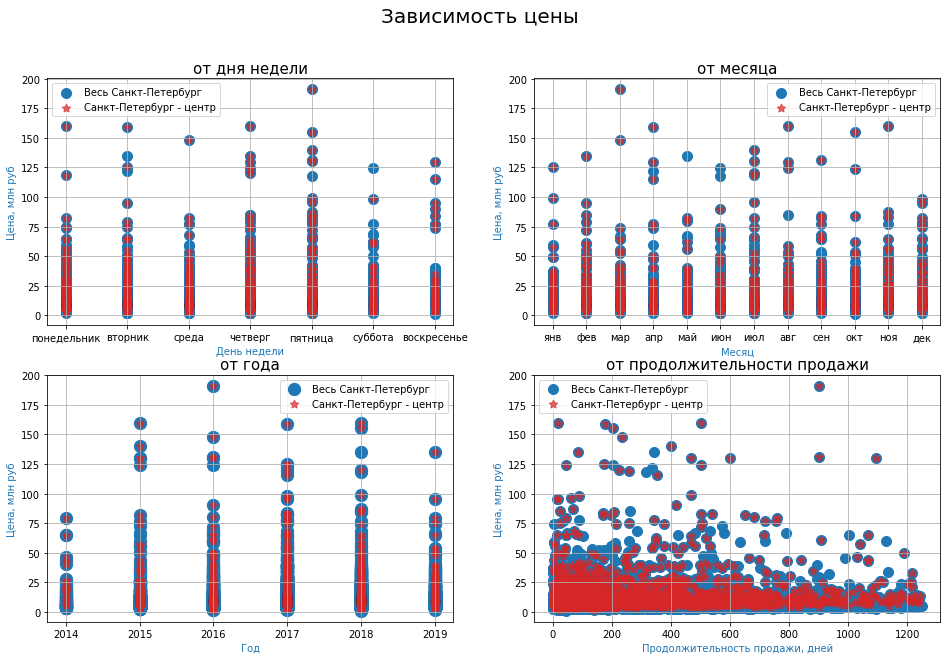

In [80]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10))
x0, a0 = spb_center['first_expositioned_weekday'], spb['first_expositioned_weekday']
x1, a1 = spb_center['first_expositioned_month'], spb['first_expositioned_month']
x2, a2 = spb_center['first_expositioned_year'], spb['first_expositioned_year']
x3, a3 = spb_center['days_expositioned'], spb['days_expositioned']
y, b = spb_center['last_price_mln'], spb['last_price_mln']

#  график по дням недели
ax0.scatter(a0, b, s=100, c='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax0.scatter(x0, y, s=75, c='tab:red', alpha=.7, label='Санкт-Петербург - центр', marker=(5, 1))
ax0.set_title('от дня недели', fontsize=15)
ax0.set_xlabel('День недели', fontsize=10, color='tab:blue')
ax0.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax0.set_xticklabels(['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.legend()
ax0.grid(True)

#  график по месяцам
ax1.scatter(a1, b, s=100, c='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax1.scatter(x1, y, s=75, c='tab:red', alpha=.7, label='Санкт-Петербург - центр', marker=(5, 1))
ax1.set_title('от месяца', fontsize=15)
ax1.set_xlabel('Месяц', fontsize=10, color='tab:blue')
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_xticklabels(['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.legend()
ax1.grid(True)

#  график по годам
ax2.scatter(a2, b, s=150, c='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax2.scatter(x2, y, s=75, c='tab:red', alpha=.7, label='Санкт-Петербург - центр', marker=(5, 1))
ax2.set_title('от года', fontsize=15)
ax2.set_xlabel('Год', fontsize=10, color='tab:blue')
ax2.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.legend()
ax2.grid(True)

# график по продолжительности продажи
ax3.scatter(a3, b, s=100, c='tab:blue', alpha=1, label='Весь Санкт-Петербург')
ax3.scatter(x3, y, s=75, c='tab:red', alpha=.7, label='Санкт-Петербург - центр', marker=(5, 1))
ax3.set_title('от продолжительности продажи', fontsize=15)
ax3.set_xlabel('Продолжительность продажи, дней', fontsize=10, color='tab:blue')
ax3.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax3.legend()
ax3.grid(True)

fig.suptitle('Зависимость цены', fontsize=20)
plt.show()

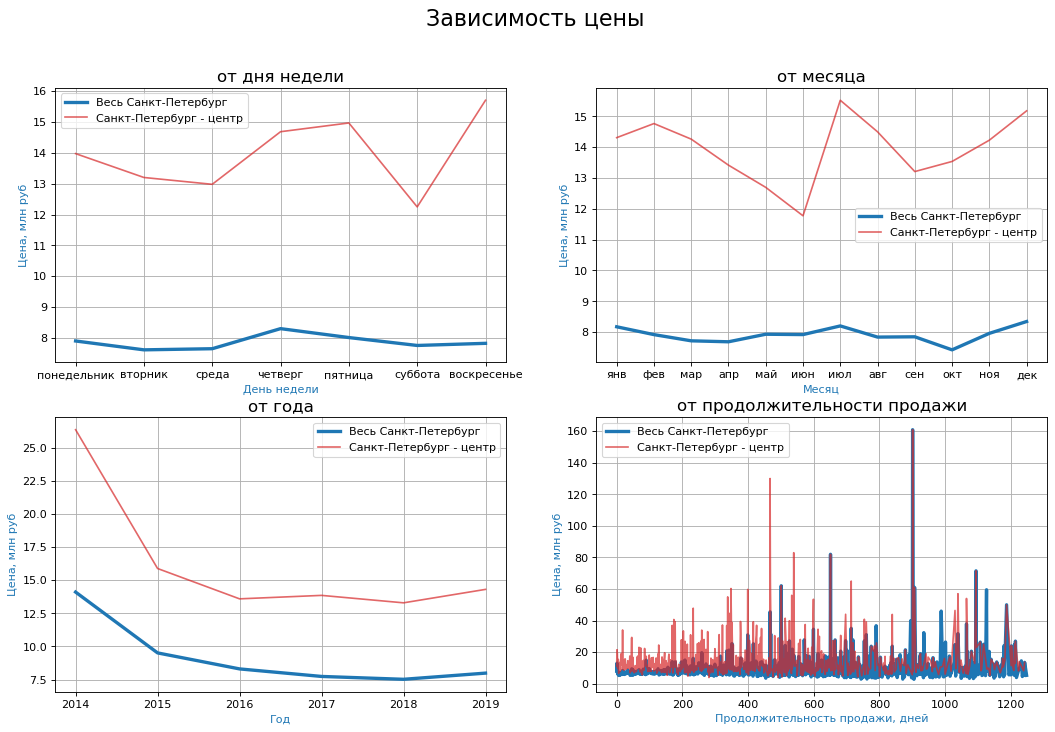

In [81]:
weekday_spb_pivot = spb.pivot_table(index='first_expositioned_weekday', values='last_price_mln', aggfunc=['mean'])
month_spb_pivot = spb.pivot_table(index='first_expositioned_month', values='last_price_mln', aggfunc=['mean'])
year_spb_pivot = spb.pivot_table(index='first_expositioned_year', values='last_price_mln', aggfunc=['mean'])
days_spb_pivot = spb.pivot_table(index='days_expositioned', values='last_price_mln', aggfunc=['mean'])

weekday_spb_center_pivot = spb_center.pivot_table(index='first_expositioned_weekday', values='last_price_mln', aggfunc=['mean'])
month_spb_center_pivot = spb_center.pivot_table(index='first_expositioned_month', values='last_price_mln', aggfunc=['mean'])
year_spb_center_pivot = spb_center.pivot_table(index='first_expositioned_year', values='last_price_mln', aggfunc=['mean'])
days_spb_center_pivot = spb_center.pivot_table(index='days_expositioned', values='last_price_mln', aggfunc=['mean'])

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16, 10), dpi=80)

x0, x1 = weekday_spb_pivot.index, weekday_spb_center_pivot.index
x2, x3 = month_spb_pivot.index, month_spb_center_pivot.index
x4, x5 = year_spb_pivot.index, year_spb_center_pivot.index
x6, x7 = days_spb_pivot.index, days_spb_center_pivot.index

y0, y1 = weekday_spb_pivot[('mean', 'last_price_mln')], weekday_spb_center_pivot[('mean', 'last_price_mln')]
y2, y3 = month_spb_pivot[('mean', 'last_price_mln')], month_spb_center_pivot[('mean', 'last_price_mln')]
y4, y5 = year_spb_pivot[('mean', 'last_price_mln')], year_spb_center_pivot[('mean', 'last_price_mln')]
y6, y7 = days_spb_pivot[('mean', 'last_price_mln')], days_spb_center_pivot[('mean', 'last_price_mln')]

#  график по дням недели
ax0.plot(x0, y0, c='tab:blue', linewidth=3)
ax0.plot(x1, y1, c='tab:red', alpha=.7)
ax0.set_xlabel('День недели', fontsize=10, color='tab:blue')
ax0.set_xticks([0, 1, 2, 3, 4, 5, 6]) 
ax0.set_xticklabels(['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье'])
ax0.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax0.set_title('от дня недели', fontsize=15)
ax0.legend(['Весь Санкт-Петербург', 'Санкт-Петербург - центр'])
ax0.grid(True)

#  график по месяцам
ax1.plot(x2, y2, c='tab:blue', linewidth=3)
ax1.plot(x3, y3, c='tab:red', alpha=.7)
ax1.set_title('от месяца', fontsize=15)
ax1.set_xlabel('Месяц', fontsize=10, color='tab:blue')
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax1.set_xticklabels(['янв', 'фев', 'мар', 'апр', 'май', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек'])
ax1.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax1.legend(['Весь Санкт-Петербург', 'Санкт-Петербург - центр'])
ax1.grid(True)

#  график по годам
ax2.plot(x4, y4, c='tab:blue', linewidth=3)
ax2.plot(x5, y5, c='tab:red', alpha=.7)
ax2.set_title('от года', fontsize=15)
ax2.set_xlabel('Год', fontsize=10, color='tab:blue')
ax2.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax2.legend(['Весь Санкт-Петербург', 'Санкт-Петербург - центр'])
ax2.grid(True)

# график по продолжительности продажи
ax3.plot(x6, y6, c='tab:blue', linewidth=3)
ax3.plot(x7, y7, c='tab:red', alpha=.7)
ax3.set_title('от продолжительности продажи', fontsize=15)
ax3.set_xlabel('Продолжительность продажи, дней', fontsize=10, color='tab:blue')
ax3.set_ylabel('Цена, млн руб', fontsize=10, color='tab:blue')
ax3.legend(['Весь Санкт-Петербург', 'Санкт-Петербург - центр'])
ax3.grid(True)

fig.suptitle('Зависимость цены', fontsize=20)
plt.show()

Теперь рассмотрим как различается в центре и в области зависимость цены от временных факторов.

По дню недели &mdash; суббота так же оказалась самым дешёвым днём, как и во всей области, однако в части самого дорогого дня тут совершенно другая ситуация &mdash; лидером на этот раз оказалось воскресенье. При этом цены в центре (естественно) значительно выше, сильно выпадает только суббота. А вот Санкт-Петербург в целом слегка отличился и от центра и от всей области: тут самые дешёвые объявления появляются во вторник, а самые дорогие в четверг. 

По году &mdash; тут сюрпризов не оказалось. Просто дороже. И просто сильнее упало в 2015. Видна попытка слегка вырасти в 2017, однако затем последовало падение в 2018.

По месяцу &mdash; тут тоже слегка другие тенденции, лидер по цене всё так же июль, а вот аутсайдер не октябрь, а июнь. Кроме того, график выглядит более симметрично, заметны только два больших пика в июне-июле, в остальное время изменения более плавные. Город в целом повторяет областную картину с пиками июль-октябрь.

По продолжительности продажи &mdash; тут центр оказался интереснее. Получается, что те значения из общего графика, которые скорее росли в цене, относились в большей части к предложениям из центра. Кроме того, большая часть максимальных значений опять же относится к центру. Тут город в целом тоже скорее повторяет тенденции области.

[к началу шага](#4-5) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="5"></a>
## Этап 5. Общий вывод

<a id="5-1"></a>
### Шаг 5.1 Результаты исследования

В этом исследовании нас интересовали ответы на следующие вопросы:

- Сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?
- Зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра, от даты размещения: дня недели, месяца и года?
- Какие особенности по площади, цене, числу комнат, высоте потолков присущи сегменту квартир в центре?
- Как отличается сегмент квартир в центре города от всей совокупности квартир?

**Общие результаты**

Большая часть вышеуказанных параметров влияет на ценообразование. Самыми влиятельными можно назвать расположение и площадь. Остальные параметры тоже влияют на цену, но не так очевидно.

Кроме того, можно отметить, что продажи квартир имеют сезонные тенденции, а если брать промежуток в несколько лет, то цены на рынке заметно снизились.

Центр оказался уникальным сегментом со своими собственными характеристиками ценообразования. Даже разница между центром и городом более явная, чем между городом и областью, хотя и она, очевидно присутствует.

Основываясь на результатах исследования, можно сказать, что для центра скорее характерны дорогие и просторные квартиры с высокими потолками, а для области в целом ситуация другая &mdash; тут доминируют дешёвые небольшие квартиры с низкими потолками, присутствуют и одноэтажные дома.

Кроме того, результаты этого исследования целесообразно учесть при построении автоматизированной системы для отслеживания аномалий.

**Рекомендации**

С точки зрения предотвращения абъюза бесплатных объявлений желательно разработать систему проверки дублирующихся объявлений. Желательно использовать целочисленные характеристики, которые придают объекту недвижимости уникальность и при этом являются стабильными и важными, чтобы владелец не мог вольно менять эти значения. К примеру, в рамках этогого исследования использовались такие параметры как количество балконов, расстояние до центра города, этаж и населённый пункт. Однако, при разработке системы можно учесть и использование других значений, в том числе дробных, таких как: площадь, цена за квадратный метр, геолокация, высота потолка. Но при условии того, что будет заложена некая вариативность, иначе владелец может просто незначительно изменить дробные характеристики получив уникальность без особых усилий.

Так же желательно проверить систему, которая автоматически выставляет характеристики квартирам, например расстояние до парков, водоёмов и аэропортов. Очень много значений пропущено, возможна ошибка при расчетах, или при выгрузке данных.

Характеристика отвечающая за то, является ли продаваемая недвижимость апартаментами также нуждается в настройке. Этот параметр имеет наибольшее количество пропущенных значений. Возможно это связано с тем, что он необязательный, и мало кто им пользуется. Однако этот параметр по определению является важным с точки зрения ценообразования, и даёт достаточно много информации при том, что самостоятельно не вытекает из других параметров, и восстановить его по ним практически невозможно.

Так же, для отсеивания неадекватных объявлений необходимо установить ограничения для полей ввода при помощи правил проверки. С учетом результатов исследования, целесообразным является ограничение минимальных значений для полей цены, общей площади, количества комнат и высоты потолков. Установление максимальных значений также возможно, но должно учитывать возможности уникальных предложений недвижимости.

[к началу шага](#5-1) | [к началу этапа](#5) | [к началу страницы](#top)